## Final Modifications: Making a super class AudibleTransits, with subclasses AudibleTransitsADSB and AudibleTransitsGPS
### The class will contain attributes that correspond with a given listener (e.g., a microphone):
- active space
- mic location
- crs
- study area
- digital elevation model (DEM)
- tracks (this will be the current set of tracks that are being operated on)
- Potentially older versions of the tracks (e.g., raw tracks, interpolated tracks, clipped tracks)
- Potentially garbage tracks, extrapolated tracks for data validation
- event binary stack
- noise-free interval (NFI) binary stack
- stats dataframes (maybe list of dataframes?)
### The main pipeline of methods:
- interpolate_tracks()
- clip_tracks()
- clean_tracks()
- extrapolate_tracks()
- Along with: update_track_parameters(), update_trackQC()

### will have a somewhat standard look:
    def method(self, tracks='self')
        if tracks == 'self':
            tracks = self.tracks
            self_flag = True
#### This gives us the option to use these methods in the main pipeline, while also reserving the ability for usage on any specified tracks. See extrapolate_tracks() for a good example of how some of these methods may be used on subsections of the main tracks, requiring usage of this 'tracks' argument.
#### It's worth keeping in mind that setting newGDF = oldGDF is actually passing the pointer to the oldGDF to the newGDF. This can be helpful sometimes, but also can cause inadvertent changes to the original GDF. Use gdf.copy() in situations where you don't want the two dataframes connected




In [ ]:
# CHECKPT

In [1]:
## =================================== IMPORTS =============================================== ##
#geospatial libraries
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly
import geopandas as gpd
import pyproj
import rasterio
import rasterio.plot
from rasterio.windows import Window
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString, Polygon
from shapely import ops

# other libraries
import datetime as dt
import fiona
import glob
from itertools import islice
import json
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.tri import Triangulation
from matplotlib.widgets import RangeSlider, Button, Slider, RadioButtons
import numpy as np
import os
import pandas as pd
import pickle
import re
from scipy import interpolate, stats
from scipy.ndimage import median_filter
import sqlalchemy
import subprocess
import sys
import time
from tqdm import tqdm
import warnings
import geopy as geopy
from geopy.distance import geodesic
from time import mktime, sleep
import math
import ipykernel

# find Sam's overflights database scrips
RDS = r"\\inpdenaterm01\overflights"
sys.path.append(os.path.join(RDS, "scripts"))
from query_tracks import query_tracks, get_mask_wkt
# =======================================================================================================
repo_dir = r"C:\Users\jbrotman-krass\Documents\PythonScripts" # ADJUST TO YOUR LOCAL DIRECTORY
# =======================================================================================================
sys.path.append(os.path.join(repo_dir, r"NPS-ActiveSpace\nps_active_space\utils"))
from computation import interpolate_spline
from models import Tracks, Adsb



C:\Users\jbrotman-krass\AppData\Local\miniforge3\envs\active\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
class AudibleTransits:
    def __init__(self, metadata, paths):
        self.unit = metadata["unit"]
        self.site = metadata["site"]
        self.year = metadata["year"]
        self.gain = metadata["gain"]
        self.study_start = metadata["study start"]
        self.study_end = metadata["study end"]
        self.database_type = metadata["database type"]
        
        self.paths = paths
        
    def init_spatial_data(self):
        '''
        Load all spatial data: the active space, study area, and mic location.
        
        Parameters
        ----------
        u : string
            Unit that the active space resides in (ex: 'DENA')
        s : string
            The active space's site name (ex: 'TRLA')
        y : int, 4 digits
            The year that the active space was calculated in (ex: 2019)
        gain : float
            The optimal gain, or scaling factor, of the active space, determined during ground truthing
    
        Returns
        -------
        active_space : GeoDataFrame
            GeoDataFrame containing all geometries of the active space. Can be a single polygon or a multipolygon.
        study_area : GeoDataFrame
            GeoDataFrame containing the geometry of the study area. A single polygon.
        mic_loc : GeoDataFrame
            GeoDataFrame containing the mic's point in the xy plane, as well as the mic height (z above ground level) in its own column. 
            Should be in the equal area UTM zone.
        '''
        warnings.filterwarnings('ignore', message=".*Results from 'centroid' are likely incorrect.*")
        
        print(" Loading Active Space and Study Area ")
        #Load in active space and study area
        active = AudibleTransits.load_activespace(self.unit, self.site, self.year, self.gain, crs="epsg:4326")
        original_study_area = AudibleTransits.load_studyarea(self.unit, self.site, self.year, crs="epsg:4326")
        
        # Calculate the UTM equal area crs from the centroid of the active space
        self.utm_zone = AudibleTransits.coords_to_utm(lat=active.centroid.y.iloc[0], lon=active.centroid.x.iloc[0])
        # Calculate mic crs (from NMSIM, uses western-most bound of the study area) MAY BE DIFFERENT
        mic_crs = AudibleTransits.NMSIM_bbox_utm(original_study_area)
        
        # Load in mic location, convert from the NMSIM crs to the UTM zone at the centroid of the active space
        mic_loc = AudibleTransits.load_miclocation(self.unit, self.site, self.year, crs=mic_crs).to_crs(self.utm_zone)

        # Plot each in the standard lon/lat geographic crs
        fig, ax = plt.subplots(1, 1, figsize=(7, 7))
        active.boundary.plot(ax=ax, color="black", zorder=1)
        mic_loc.to_crs(active.crs).plot(ax=ax, markersize=10, marker='x', color='r')
        plt.show()

        self.active = active.copy()
        self.mic = mic_loc.copy()
        
        return active, mic_loc

    def load_DEM(self):
        # Load in digital elevation model (DEM)
        raster_path = glob.glob(os.path.join(r"V:\NMSim\01 SITES", self.unit + self.site + r"\Input_Data\01_ELEVATION\elevation_m_nad83_utm*.tif"))[0]# Open raster
        ras = rasterio.open(raster_path)
        self.DEM = ras
        
    def load_tracks_from_database(self):
        pass

    def convert_tracks_to_utm(self, tracks='self'):
        '''
        Convert tracks to UTM zone. Requires the attribute anlytics.utm_zone to be already determined (see init_spatial_data())

        Parameters
        ----------
        tracks: GeoDataFrame
            Geodataframe containing all tracks (as points)
        '''
        if type(tracks) is str:
            tracks=self.tracks
            self_flag = True
        else:
            self_flag = False
            
        # the tracks come in the standard lon/lat geographic crs
        tracks = tracks.set_crs('WGS84') 
        
        # Convert to the equal area UTM zone, as determined previously and saved as attribute utm_zone
        utm_tracks = tracks.to_crs(self.utm_zone)
        
        # Create Shapely Point objects for each geometry using the previously saved xy points and altitude MSL
        utm_tracks.geometry = gpd.points_from_xy(utm_tracks.geometry.x, utm_tracks.geometry.y, utm_tracks.z)

        if self_flag:
            self.tracks = utm_tracks.copy()
        
        return utm_tracks

    def convert_active_to_utm(self):
        utm_active = self.active.to_crs(self.utm_zone)
        self.active = utm_active.copy()
        return utm_active
        
    def create_track_segments(self):
        pass

    def simplify_active_space(self, inplace=True):
        
        # Simplify active space boundaries within a tolerance of 100 meters 
        # (kind of arbitrary, but visually seems to prevent overly fragmented audible transits)
        active_ea_simple = self.active.simplify(100)
        
        # Select out the largest polygon if the Active Space is a MultiPolygon to remove small islands, for simplicity
        if active_ea_simple.geometry.iloc[0].geom_type == 'MultiPolygon':
            polygons = list(active_ea_simple.geometry.iloc[0].geoms)
            active_ea_simple = gpd.GeoSeries(polygons[np.argmax([poly.area for poly in polygons])], crs=self.active.crs) # Select largest polygon
            print("Largest polygon chosen as active space")

        # Make a plot to illustrate the active space simplifications
        fig, ax = plt.subplots(1,1,figsize=(6,6))
        self.active.boundary.plot(color='k', ax=ax, label='original')
        active_ea_simple.boundary.plot(color='r', ax=ax, label='simplified')
        ax.legend()
        ax.set_title("Active Space Simplified")

        if (inplace):
            self.active = active_ea_simple.copy()
        else:
            return active_ea_simple
        
    def update_trackQC(self, tracks='self'):
        '''
        Update some information about each track's preparedness for analysis. Will add or update existing columns. 
        Includes the following:
                                - needs_extrapolation: whether a track endpoint is inside of the active space -- see needs_extrapolation()
                                - needs_glue: a bug from clipping, indicates whether a track needs to be repaired -- see needs_glue()
                                - short_distance: whether a track travels less than a preset threshold, generally 100 meters -- see find_short_tracks()
                                - speed_out_of_range: whether a flight's speed is outside of a realistic range -- see find_err_flight_speeds()
        
        Parameters
        ----------
        tracks : GeoDataFrame
            GeoDataFrame of flight tracks, requires basic parameters of the tracks:
                entry_time | exit_time | entry_position | exit_position | transit_distance
         
        Returns
        -------
        None, just adds/updates columns in 'tracks' 
        '''
        if type(tracks) is str:
            tracks=self.tracks
            
        print("=============================================")
        print("------------- Updating track QC -------------")
        print(" - needs extrapolation")
        AudibleTransits.needs_extrapolation(tracks, self.active)
        print(" - needs glue")
        AudibleTransits.needs_glue(tracks, self.active)
        # TODO attribute for
        print(" - very short track")
        AudibleTransits.find_short_tracks(tracks, max_distance=100)
        print(" - erroneous flight speed")
        AudibleTransits.find_err_flight_speeds(tracks, min_speed=1, max_speed=100)
        print("------------ Track QC Completed -------------")
        print("=============================================")

    def update_track_parameters(self, tracks='self'):
        '''
        Updates physical paramters of each track. 
        Includes the following:
                                - entry_time and exit_time: datetimes at the beginning and end of a track
                                - entry_position and exit_position: Shapely Points at the beginning and end of a track
                                - transit_duration: total time inside active space for each track, in seconds
                                - transit_distance: the length of the LineString that represents the track, in meters
                                - avg_speed: the average speed of the track, taken as distance/duration in meters/second
        
        Parameters
        ----------
        tracks : GeoDataFrame
            GeoDataFrame of flight tracks, requires interpolated geometries and times:
                interp_goemetry | interp_point_dt
         
        Returns
        -------
        None, just adds/updates columns in 'tracks'
        '''
        if type(tracks) is str:
            tracks=self.tracks

        print("--------- Updating track parameters ---------")
        
        if 'interp_geometry' not in tracks:
            print("Error: No interpolated geometry found (column = 'interp_geometry'). Cannot update track parameters.")
            return 0
        
        # Initialize lists to store each entry/exit postion and time, as well as the total event duration for each track
        entry_pos = []
        exit_pos = []
        entry_times = []
        exit_times = []
        transit_durations = []

        print("Extracting entry/exit positions")
        # Extract the initial and final coordinate from each track's LineString
        for spline in tracks['interp_geometry']:
            entry_pos.append(Point(spline.coords[0]))
            exit_pos.append(Point(spline.coords[-1]))
    
        print("Extracting entry/exit times")
        # Extract the initial and final times (+ duration) from each track's timestamp list
        for timelist in tracks['interp_point_dt']:
            entry_times.append(timelist[0])
            exit_times.append(timelist[-1])
            transit_durations.append((timelist[-1] - timelist[0])/ pd.Timedelta(seconds = 1))
            
        # Add entry and exit times to clipped_tracks GeoDataFrame
        tracks["entry_time"] = entry_times
        tracks["exit_time"] = exit_times
        # Add entry and exit points to clipped_tracks GeoDataFrame
        tracks["entry_position"] = gpd.GeoSeries(entry_pos, index=tracks.index, crs=self.tracks.crs)
        tracks["exit_position"] = gpd.GeoSeries(exit_pos, index=tracks.index, crs=self.tracks.crs)
        # Calculate and add transit duration, distance, and average speed to clipped_tracks Geodataframe
        print("Calculating transit duration")
        tracks["transit_duration"] = transit_durations
        print("Calculating transit distance")
        tracks["transit_distance"] = tracks.length
        print("Calculating average speed")
        tracks["avg_speed"] = tracks.transit_distance / tracks.transit_duration

        print("----- Track parameters update completed -----")
        print("=============================================")

    def summarize_data_quality(self, tracks='self'):
        
        if type(tracks) is str:
            tracks=self.tracks

        num_tracks = len(tracks)
        print("----------- Data Quality Summary ------------")
        print(f"Needs Extrapolation: {tracks.needs_extrapolation.sum()}  ....  {round(100*tracks.needs_extrapolation.sum()/num_tracks,2)} %")
        print(f"Needs Glue: {tracks.needs_glue.sum()}  ....  {round(100*tracks.needs_glue.sum()/num_tracks, 2)}%")
        print(f"Short Tracks: {tracks.short_distance.sum()}  ....  {round(100*tracks.short_distance.sum()/num_tracks, 2)}%")
        print(f"Erroneous Average Flight Speed: {tracks.speed_out_of_range.sum()}  ....  {round(100*tracks.speed_out_of_range.sum()/num_tracks, 2)}%")
        print(f"Out of {num_tracks} total tracks")
        print("=============================================")

    def interpolate_tracks(self, tracks='self'):
        '''
        Interpolates raw tracks to 1 second time intervals, mainly using cubic splines. This method uses SciPy's interpolate library. 
        See interpolate_spline2() for more details.
        
        Parameters
        ----------
        tracks : GeoDataFrame
            GeoDataFrame of uninterpolated flight tracks, requires basic track elements:
                goemetry_pts | geometry | point_dt
         
        Returns
        -------
        interp_tracks : GeoDataFrame
            GeoDataFrame of interpolated flight tracks, which will replace tracks':
                                                                                    'geometry' --> 'interp_geometry'
                                                                                    'point_dt' --> 'interp_point_dt'
        '''
        if type(tracks) is str:
            tracks=self.tracks
            self_flag = True
        else:
            self_flag = False
            
        print("Interpolating tracks, may take a few minutes:")
        
        if 'geometry_pts' not in tracks:
            print("Error: Cannot perform interpolation. Tracks missing column 'geometry_pts'")
            return 0
        ###### INTERPOLATION =================================================================================#

        # Break each track multipoint down to individual points (Timestamp still needs to be dealt with)
        sorted_tracks = tracks.dissolve(by='track_id')
        sorted_tracks_pts = sorted_tracks.set_geometry('geometry_pts')  
        sorted_tracks_pts = sorted_tracks_pts.explode('geometry', index_parts=True) 
        sorted_tracks_pts['z'] = sorted_tracks_pts.geometry.z
        
        track_id_list = []     # List to store interpolated track id's (exclude failures)
        n_number_list = []     # List to store N-numbers
        aircraft_type_list = []   # List to store aircraft types
        poor_track_list = []   # List to store flags for tracks with poor data quality
        num_points_list = []
        sampling_interval_list = []
        spline_time_list = []  # List to store lists of interpolated times for resulting splines
        spline_line_list = []  # List to store resulting interpolated LineStrings
        interp_flag_list = []
        # At the end, we'll take all these lists and turn them into a GeoDataFrame
        
        # LOOP THROUGH EACH FLIGHT ID AND INTERPOLATE THE TRACK
        for track_id, track_pts in tqdm(sorted_tracks_pts.groupby(level=0), unit=" splines"):
            # Currently, each track point has the entire list of timestamps in its respective row
            # We want to assign each timestamp to its respective track point. Store full list in 'timestamps'
            timestamps = track_pts.point_dt[0]
            

            # Check for weird case where timestamps don't line up with the number of rows...
            if len(track_pts) == len(timestamps):
                track_id_list.append(track_id)  # Add track ID to list
                n_number_list.append(track_pts.iloc[0].n_number)
                aircraft_type_list.append(track_pts.iloc[0].aircraft_type)
                poor_track_list.append(track_pts.iloc[0].poor_track)
                num_points_list.append(track_pts.iloc[0].num_points)
                sampling_interval_list.append(track_pts.iloc[0].sampling_interval)
                track_pts["point_dt"] = timestamps  # Add timestamps list as a column to geodataframe. Only works if correct size, hence the above conditional   

                # Interpolate spline given this new gdf with rows of track points and timestamps, then extract coordinates
                track_spline = AudibleTransits.interpolate_spline2(track_pts, s=0)  
                spline_points = [(x,y,z) for x,y,z in zip(track_spline.geometry.x, track_spline.geometry.y, track_spline.geometry.z)] 
                
                spline_line = LineString(spline_points)  # Turn points into a LineString
                spline_line_list.append(spline_line)  # Add LineString to list
                
                # Convert spline timestamps to a pandas Series to convert to datetime64, add list of timestamps to spline_time_list (list of lists)
                spline_time = pd.Series([time for time in track_spline.point_dt])  
                spline_time_list.append(pd.to_datetime(spline_time).values)
                
                interp_flag_list.append(track_spline.iloc[0].interp_flag > 0)  

            else:
                track_pts["point_dt"] = np.zeros(len(track_pts))
                print("timestamps: ", len(timestamps), ",  track_pts: ", len(track_pts))
                print("Numer of timestamps doesn't line up with number of rows")

        # Create new GeoDataFrame with track IDs, interpolated track points and timestamps
        interp_tracks = gpd.GeoDataFrame(index=track_id_list, geometry='interp_geometry', columns=['interp_point_dt', 'interp_geometry'], crs=self.tracks.crs) 
        interp_tracks['interp_point_dt'] = spline_time_list
        interp_tracks['interp_geometry'] = spline_line_list
        interp_tracks['n_number'] = n_number_list
        interp_tracks['aircraft_type'] = aircraft_type_list
        interp_tracks['interp_flag'] = interp_flag_list
        interp_tracks['poor_track'] = poor_track_list
        interp_tracks['num_points'] = num_points_list
        interp_tracks['sampling_interval'] = sampling_interval_list
        interp_tracks.set_geometry('interp_geometry', inplace=True)

        print("---------- Interpolation completed ----------")
        print("=============================================")

        if (self_flag):
            self.tracks = interp_tracks.copy()
            
        return interp_tracks

    def clip_tracks(self, tracks='self'):
        '''
        Clips tracks to the active space, cutting out any parts of tracks exterior to the active space polygon.
        Unfortunately, LineString coordinates are not connected to their respective timestamps, so we need to manually find and align timestamps
        to the clipped tracks (there can be many clipped tracks for each individual flight; e.g., track goes back and forth across active space).
        
        Parameters
        ----------
        tracks : GeoDataFrame
            GeoDataFrame of interpolated flight tracks, requires basic track elements:
                interp_geometry | interp_point_dt
                
        Returns
        -------
        interp_tracks : GeoDataFrame
            GeoDataFrame of clipped flight tracks. At this point, track_id's can no longer be used as indices, as they will not be unique. 
        '''        

        if type(tracks) is str:
            tracks=self.tracks
            self_flag = True
        else:
            self_flag = False
        
        print("------ Clipping tracks to active space ------")
        
        if 'interp_geometry' not in tracks:
            print("Error: No interpolated geometry found (column = 'interp_geometry'). Cannot clip tracks to active space.")
            return 0        
            
        #### CLIPPING tracks to active space ===================================================#
        tracks['preclip_id'] = np.arange(0, len(tracks))
        clipped_tracks = tracks.clip(self.active).copy()
        clipped_tracks.reset_index(inplace=True)
        if 'track_id' not in clipped_tracks:
            clipped_tracks.rename(columns = {'index':'track_id'}, inplace = True)
        clipped_tracks = clipped_tracks.explode('interp_geometry',ignore_index=True) 
        # Reorder and remove extra columns -- we can always repopulate
        #clipped_tracks = clipped_tracks[['preclip_id', 'track_id', 'interp_point_dt', 'interp_geometry', 'interp_flag', 'poor_track', 'num_points', 'sampling_interval']]
        
        # NEED TO EXPLODE TIMESTAMPS, TOO
        print("Adjusting timestamps to clipped tracks")
        prev_id = np.nan
        real_timestamps = []
        for idx, clipped_track in tqdm(clipped_tracks.iterrows(), unit=' tracks adjusted'):
            this_time = []
            id = clipped_track.preclip_id
                    
            if id != prev_id:
                ### New track
                iii=0
                initial_index = 0
                final_index = 0
                center_idx = 0
                prev_coords = tuple([[0, 0, 0],[0, 0, 0]])
                
            unclipped_track = tracks[tracks.preclip_id == id].iloc[0]
            timestamp_list = unclipped_track.interp_point_dt   # Extract timestamps (list) of unclipped track
            clipped_coords = tuple(clipped_track.interp_geometry.coords)   # Convert clipped track coordinates to a list of tuples
            unclipped_coords = tuple(unclipped_track.interp_geometry.coords)
            current_index = 0  # Keeping track of index
            # If clipped track contains more than 2 points, we can use the following algorithm 
            # NOTE: endpoints likely do not exist in the original interpolated track
            found_match = False
            if len(clipped_coords) > 2: 
                # Find the index of the unclipped track's coordinate that is an identical match to the 1st non-endpoint clipped track's coordinate
                for x,y,z in unclipped_coords:
                    if x == clipped_coords[1][0]:
                        if y == clipped_coords[1][1]:
                            # It's a match! Set as the initial coordinate and leave the for loop
                            initial_index = current_index
                            found_match = True
                            break
                    current_index=current_index+1
                # Set final index of unclipped track, lines up with the last coordinate of the clipped track before the endpoint
                final_index = initial_index + len(clipped_coords) - 3
                # Isolate the desired timestamps, include the final index
                this_time = timestamp_list[initial_index:final_index+1]
                # Estimate the endpoints at the boundary
                start_time, end_time = AudibleTransits.calculate_boundary_times(timestamp_list, initial_index, final_index, unclipped_coords, clipped_coords)
                # Add in the start time and end time at the boundary
                this_time = np.insert(this_time, 0, start_time)
                this_time = np.append(this_time, end_time)
                if found_match==False:
                    print('uh oh')
            else:
                ## This is a weird case, both coordinates are clipped endpoints--they do not exist in the interpolation, so finding the corresponding time is difficult
                ## We only need to keep these miniscule 2-point tracks if they're part of a long chain of glue-needing track clips
                if clipped_coords[0][0] == prev_coords[-1][0]:
                    # Assume that if the last coord of the previous track is the same as the first coord of the current track, they should be sequential
                    #print("tiny clip error", clipped_track.track_id)
                    center_idx = final_index  ## Use the previous final index to be the center of this tiny track
                else:
                    ### This will get thrown out anyway, almost certainly (short track, not glue)
                    middle_coord = (np.array(clipped_coords[0]) + np.array(clipped_coords[-1])) / 2
                    distances = np.linalg.norm(np.array(unclipped_track.interp_geometry.coords)-middle_coord, axis=1)
                    center_idx = distances.argmin()  # Find the index of the closest coordinate to the average of the two points
                    
                this_time = [timestamp_list[center_idx]-np.timedelta64(500,'ms'), timestamp_list[center_idx]+np.timedelta64(500,'ms')]
                
            real_timestamps.append(this_time)
            prev_coords = clipped_coords
            prev_id = id
            
        clipped_tracks['interp_point_dt'] = real_timestamps
        
        print("------------- Tracks clipped ----------------")
        print("=============================================")
        
        if (self_flag):
            self.tracks = clipped_tracks.copy()
        
        return clipped_tracks
    
    def clean_tracks(self, tracks='self'):
        '''
        Perform essential data cleaning on tracks. These operations include:
            1) Remove tracks that are comprised of a single point (instead of a line)
            2) Glue together tracks that are broken by self intersection -- this is essentially a bug patch -- see glue_tracks()
            3) Remove tracks that are less than 10 seconds (unlikely to be annotated)
            4) Remove tracks that have 0 or infinite average flight speeds (physically impossible, indicates bad data)
            5) Remove tracks that have still somehow managed to be outside the active space -- no clue why clip didn't get rid of them        
        
        Parameters
        ----------
        tracks : GeoDataFrame
            GeoDataFrame of flight tracks, requires track parameters and QC columns:
                interp_geometry | entry_time | exit_time | entry_position | exit_position | transit_duration | avg_speed
                
        Returns
        -------
        cleaned_tracks : GeoDataFrame
            GeoDataFrame of cleaned flight tracks
        '''        
        if type(tracks) is str:
            tracks=self.tracks
            self_flag = True
        else:
            self_flag = False
        
        print("-------------- Cleaning tracks --------------")
        
        print("getting rid of single points...")
        cleaned_tracks = tracks.copy().loc[tracks.interp_geometry.geom_type != "Point"]
        
        print("glueing up segmented tracks...")
        cleaned_tracks = AudibleTransits.glue_tracks(cleaned_tracks, self.active)
        
        print("removing tracks < 10s in duration")
        cleaned_tracks = cleaned_tracks.loc[cleaned_tracks.transit_duration >= 10]
        
        print("removing tracks with avg speed = 0 or infinity...")
        cleaned_tracks = cleaned_tracks.loc[(cleaned_tracks.avg_speed != 0) & (cleaned_tracks.avg_speed != np.inf)]
        cleaned_tracks = cleaned_tracks.loc[cleaned_tracks.interp_geometry.within(self.active.geometry.iloc[0].buffer(100))]
        
        print("-------------- Tracks cleaned ---------------")
        print("=============================================")

        if (self_flag):
            self.tracks = cleaned_tracks.copy()

        return cleaned_tracks      

    def extrapolate_tracks(self, tracks='self', extrapolation_time=800, return_extrapolated=False):
        '''
        REQUIRES detect_takeoffs_and_landings() !!!!!!!!!!!
        Extrapolates tracks that start/end in the active space and have been determined to not be takeoffs or landings.
        This is a linear extrapolation, based on the first two or last two points in the track. 
        
        Parameters
        ----------
        tracks : GeoDataFrame
            GeoDataFrame of flight tracks, requires track parameters and QC columns that indicate a need to extrapolate:
                interp_geometry | interp_point_dt | needs_extrapolation | starts_inside | ends_inside | takeoff | landing
        extrapolation_time : int (in seconds)
            Defaults to 800 s, determines how long to extrapolate tracks for. Tradeoff between extrapolation not being completed vs. lots of 
            computation time.
        return_extrapolated : boolean
            Defaults to False, determines whether the extrapolated tracks are returned as their own GeoDataFrame
         
        Returns
        -------
        new_tracks : GeoDataFrame
            GeoDataFrame of tracks that contains extrapolated tracks along with the rest that didn't require extrapolation
        extrapolated_tracks : GeoDataFrame (if return_extrapolated=True)
            GeoDataFrame of just the extrapolated tracks, is only returned if return_extrapolated is set True. This may be helpful for validation
            of extrapolation and takeoff/landing detection.
        '''        
        if type(tracks) is str:
            tracks=self.tracks
            self_flag = True
        else:
            self_flag = False
            
        print("------------ Extrapolating tracks -----------")
        
        if 'needs_extrapolation' not in tracks:
            print("Error: Cannot perform extrapolation. 'tracks' missing column 'needs_extrapolation'")
            return 0
            
        needs_extrapolation_df = tracks.loc[tracks.needs_extrapolation]
        extrapolated_tracks = needs_extrapolation_df.copy()
        
        new_times = []  # list of list of timestamps for each extrapolated track
        new_geometry = []  # list of LineStrings (one per track)
        takeoffs = []  # keep track of takeoffs and landings
        print("Extending track entries:")
        for idx, track in tqdm(needs_extrapolation_df.iterrows(), unit=' tracks'):
        
            old_geometry = track.interp_geometry  # For each track, pull out geometry and timestamps
            old_times = track.interp_point_dt
            
            ## If beginning needs extrapolation
            if (track.starts_inside & ~track.takeoff):
                points = np.asarray(old_geometry.coords)            
                ## Calculate slope between first two points
                t0 = old_times[0]
                t1 = old_times[1]
                delta_t = (t1 - t0) / np.timedelta64(1, 's')
                p0 = points[0]
                p1 = points[1]
                ## Slope dl/dt in all three directions (basically a velocity vector: Vx, Vy, and Vz)
                dldt = (p1 - p0) /delta_t
                
                ## Calculate new relative positions by multiplying each velocity component by the number of seconds before track actually begins
                ## deltaX = Vx * ticks, for example
                ticks = np.arange(-extrapolation_time, 0)
                pos_extrap = np.matmul(dldt[:,None], ticks[None,:])
                points_extrap = []
                for i in range(max(np.shape(pos_extrap))):
                    ## Create each new point (absolute, not relative) by adding the first real point -- in x, y, and z
                    point = [pos_extrap[0,i], pos_extrap[1,i], pos_extrap[2,i]] + p0
                    points_extrap.append(point)
                ## Create a LineString geometry by combining new points with old points
                new_geometry.append(LineString(np.concatenate((points_extrap, points))))
                ## Same stuff with time: Calculate new times and add to beginning of time list
                times_extrap = t0 + ticks*np.timedelta64(1, 's')
                new_times.append(list(np.concatenate((times_extrap, old_times))))
            else:
                # If beginning is fine, just pass through original geometry and time
                new_geometry.append(old_geometry)
                new_times.append(old_times)
                takeoffs.append(False)
                          
        extrapolated_tracks.interp_geometry = new_geometry
        extrapolated_tracks.interp_point_dt = new_times
            
                    
        new_times = []
        new_geometry = []
        landings = []
        print("Extending track exits:")
        for idx, track in tqdm(extrapolated_tracks.iterrows(), unit=' tracks'):
        
            old_geometry = track.interp_geometry
            old_times = track.interp_point_dt
            
            ## If ending needs extrapolation
            if (track.ends_inside & ~track.landing):
                points = np.asarray(old_geometry.coords)            
                ## Calculate slope between last two points
                t0 = old_times[-2]
                t1 = old_times[-1]
                delta_t = (t1 - t0) / np.timedelta64(1, 's')
                p0 = points[-2]
                p1 = points[-1]
                ## Slope dl/dt in all three directions (basically a velocity vector: Vx, Vy, and Vz)
                dldt = (p1 - p0) /delta_t
                
                ## Calculate new relative positions by multiplying each velocity component by the number of seconds after track actually ends
                ## deltaX = Vx * ticks, for example
                ticks = np.arange(0, extrapolation_time) + 1
                pos_extrap = np.matmul(dldt[:,None], ticks[None,:])
                points_extrap = []
                for i in range(max(np.shape(pos_extrap))):
                    ## Create each new point (absolute, not relative) by adding the last real point -- in x, y, and z -- to the relative positions
                    point = [pos_extrap[0,i], pos_extrap[1,i], pos_extrap[2,i]] + p1
                    points_extrap.append(point)
                ## Create a LineString geometry by combining new points with old points
                new_geometry.append(LineString(np.concatenate((points, points_extrap))))
                ## Same stuff with time: Calculate new times and add to beginning of time list
                times_extrap = t1 + ticks*np.timedelta64(1, 's')
                new_times.append(list(np.concatenate((old_times, times_extrap))))
            else:
                # If ending is fine, just pass through original geometry and time
                new_geometry.append(old_geometry)
                new_times.append(old_times)

        # Set extrapolated tracks' geometries and timestamps (these are just the tracks that were extrapolated)
        extrapolated_tracks.interp_geometry = new_geometry
        extrapolated_tracks.interp_point_dt = new_times

        # Clip the newly extrapolated tracks, update parameters and QC
        extrapolated_clipped = self.clip_tracks(tracks=extrapolated_tracks)
        self.update_track_parameters(tracks=extrapolated_clipped)
        self.update_trackQC(tracks=extrapolated_clipped)
        self.summarize_data_quality(tracks=extrapolated_clipped)

        # Clean the clipped, extrapolated tracks and update parameters and QC
        extrapolated_cleaned = self.clean_tracks(tracks=extrapolated_clipped)
        self.update_track_parameters(tracks=extrapolated_cleaned)
        self.update_trackQC(tracks=extrapolated_cleaned)
        self.summarize_data_quality(tracks=extrapolated_cleaned)
        
        ## Add extrapolated tracks back into full dataframe
        unextrapolated_tracks = tracks[~(tracks.needs_extrapolation)]
        new_tracks = pd.concat((unextrapolated_tracks, extrapolated_cleaned))

        print("--------- Extrapolation complete ------------")
        print("=============================================")

        if (self_flag):
            self.tracks = new_tracks.copy()
        
        if (return_extrapolated):
            return new_tracks, extrapolated_tracks
        else:
            return new_tracks

    def visualize_tracks(self, tracks_to_view='self', show_DEM=False, crs='self', show_active=True, show_mic=True, endpoints=False, title='default', fig='none', ax='none'):
        '''
        A method for visualizing tracks of any type, with or without the active space, microphone location, track endpoints, and DEM.
        Also includes options to pass a title, fig, and ax.
        '''
        
        ### TODO: add options for plotting linestrings as points, with colormapping options using other GDF columns
        if tracks_to_view=='self':
            tracks_to_view = self.tracks
            
        ## If no fig and axis are passed, generate the figure here
        if ax == 'none':
            fig, ax = plt.subplots(1,1,figsize=(6,6))

        # Turn geometry columns into separate GeoSeries'
        tracks = tracks_to_view.copy()
        active = self.active.copy()
        mic = self.mic.copy()
        tracklines = tracks.geometry
        entry_positions = tracks.entry_position
        exit_positions = tracks.exit_position
        studyA = active.buffer(25000)

        # If a DEM raster is provided, change default crs to plot in and colormap the raster
        if (show_DEM):
            crs = self.DEM.crs
            retted = rasterio.plot.show(self.DEM, ax=ax, alpha=.4, cmap='Blues_r')
            im = retted.get_images()[0]
            fig.colorbar(im, ax=ax, label='Elevation (m)')
        # If a different default crs is set, we need to reproject all geometries: active space, track lines, and entry + exit positions
        if crs != 'self':
            active = active.to_crs(crs)
            mic = mic.to_crs(crs)
            tracklines = tracklines.to_crs(crs)
            entry_positions = entry_positions.to_crs(crs)
            exit_positions = exit_positions.to_crs(crs)
            studyA = studyA.to_crs(crs)

        ## Setting bounds on the plot, priority: 1) DEM raster bounds, 2) Active space study area bounds, 3) None (tracks)
        if (show_DEM):
            minx, miny, maxx, maxy = self.DEM.bounds
            ax.set_xlim(minx, maxx)
            ax.set_ylim(miny, maxy)        
        elif (show_active):
            minx, miny, maxx, maxy = studyA.bounds.iloc[0]
            ax.set_xlim(minx, maxx)
            ax.set_ylim(miny, maxy)

        # If 'show_active' is True, plot the active space
        if (show_active):
            active.boundary.plot(ax=ax, color='grey', zorder = 4)
            aminx, aminy, amaxx, amaxy = active.bounds.iloc[0]
            ax.set_xlim(max(minx, 2*aminx-amaxx), min(maxx, 2*amaxx-aminx))
            ax.set_ylim(max(miny, 2*aminy-amaxy), min(maxy, 2*amaxy-aminy))
            
        if (show_mic):
            mic.plot(ax=ax, color='r', markersize=10, marker='*', zorder=10)

        # Automatically calculate the alpha for the tracklines based on the density of the data
        alpha = min(1, 50/len(tracks))
            
        # Plot the track lines
        tracklines.plot(ax=ax, color='k', alpha=alpha)

        # If 'endpoints' is True, plot the entries as green x's and exits as red points
        if (endpoints): 
            entry_positions.plot(marker = 'x', markersize=10, color='g', alpha=alpha, ax=ax, zorder=5)
            exit_positions.plot(marker = '.', markersize=10, color='r', alpha=alpha, ax=ax, zorder=5)

        if title=='default':
            title = f'{self.unit}{self.site} Flight Tracks'

        ax.set_title(title)
        
    # CHECKPT
    ## ========================================== INITIALIZATION UTILITIES =================================================== ##
    @staticmethod
    def load_activespace(u, s, y, gain, third_octave=True, crs=None, PROJ_DIR=r"V:\NMSim\01 SITES"):
        '''
        Load in the active space for a given unit, site, year, and gain
        
        Parameters
        ----------
        u : string
            Unit that the active space resides in (ex: 'DENA')
        s : string
            The active space's site name (ex: 'TRLA')
        y : int, 4 digits
            The year that the active space was calculated in (ex: 2019)
        gain : float
            The optimal gain, or scaling factor, of the active space, determined during ground truthing
        third_octave : boolean
            Default is True, indicates whether the gain is calculated broadband or using third-octave band data
        crs : string
            Optional argument to provide a coordinate reference system to convert the active space to (e.g.  'epsg:26905'). Defaults to None
        PROJ_DIR : string
            This is the path that leads to all sites. This function will find the right folder given the unit, site, year, and gain
            
    
        Returns
        -------
        active_space : GeoDataFrame
            GeoDataFrame containing all geometries of the active space. Can be a single polygon or a multipolygon.
        '''
        
        if gain < 0:
            sign = "-"
        else:
            sign = "+"
            
        if np.abs(gain) < 10:
            gain_string = "0" + str(np.abs(int(10*gain)))
        else:
            gain_string = str(np.abs(int(10*gain)))
        path = os.path.join(PROJ_DIR, u + s, u + s + str(y) + '_O_' + sign + gain_string + '.geojson')
        active_space = gpd.read_file(path)
        
        if crs is not None:
            active_space = active_space.to_crs(crs)
        
        return active_space

    @staticmethod
    def load_studyarea(u, s, y, crs=None, PROJ_DIR=r"V:\NMSim\01 SITES"):
        '''
        Load in the study area that contains the active space for a given unit, site, and year. Currently, this is actually being
        overridden by query_tracks(), which is set to provide a study area = active space buffered by 25km
        
        Parameters
        ----------
        u : string
            Unit that the active space resides in (ex: 'DENA')
        s : string
            The active space's site name (ex: 'TRLA')
        y : int, 4 digits
            The year that the active space was calculated in (ex: 2019)
        crs : string
            Optional argument to provide a coordinate reference system to convert the study area to (e.g.  'epsg:26905'). Defaults to None
        PROJ_DIR : string
            This is the path that leads to all sites. This function will find the right folder given the unit, site, year, and gain
            
    
        Returns
        -------
        study_area : GeoDataFrame
            GeoDataFrame containing the geometry of the study area. A single polygon.
        '''
    
        study_area_path = glob.glob(os.path.join(PROJ_DIR, u + s, u + s + '*study*area*.shp'))[0]
        study_area = gpd.read_file(study_area_path)
        
        if crs is not None:
            study_area = study_area.to_crs(crs)
            
        return study_area

    @staticmethod
    def load_miclocation(u, s, y, crs=None, PROJ_DIR=r"V:\NMSim\01 SITES"):
        '''
        Load in the mic location for the active space at a given unit, site, and year. 
        
        Parameters
        ----------
        u : string
            Unit that the active space resides in (ex: 'DENA')
        s : string
            The active space's site name (ex: 'TRLA')
        y : int, 4 digits
            The year that the active space was calculated in (ex: 2019)
        crs : string
            Optional argument to provide the coordinate reference system that the mic location is in (e.g.  'epsg:26905'). Defaults to None
        PROJ_DIR : string
            This is the path that leads to all sites. This function will find the right folder given the unit, site, year, and gain
            
    
        Returns
        -------
        mic_location : GeoDataFrame
            GeoDataFrame containing a point in the xy plane, as well as the mic height (z above ground level) in its own column
        '''
    
        mic_location_path = os.path.join(PROJ_DIR, unit+site,'Input_Data','05_SITES', unit+site + str(year) + '.sit')    
        raw_text = open(mic_location_path).read()
        
        coords_line = raw_text.splitlines()[2]
        coords_str = re.split('\s+', coords_line)[1:-1]
        x, y, z_agl = [float(i) for i in coords_str[:3]]
        mic_location = gpd.GeoDataFrame(data={'mic_height': [z_agl]}, geometry=gpd.points_from_xy([x],[y]))
        
        if crs is not None:
            mic_location = mic_location.set_crs(crs)
            
        return mic_location    
        
    @staticmethod    
    def coords_to_utm(lat: float, lon: float) -> str:
        """
        Takes the latitude and longitude of a point and outputs the EPSG code corresponding to the UTM zone of the point.
    
        Parameters
        ----------
        lat : float
            Latitude of a point in decimal degrees in a geographic coordinate system.
        lon : float
            Longitude of a point in decimal degrees in a geographic coordinate system.
    
        Returns
        -------
        utm_proj : str
            UTM zone projection name (e.g.  'epsg:26905' for UTM 5N)
    
        Notes
        -----
        Remember: x=longitude, y=latitude
        """
        # 6 degrees per zone; add 180 because zone 1 starts at 180 W.
        utm_zone = int((lon + 180) // 6 + 1)
    
        # 269 = northern hemisphere, 327 = southern hemisphere
        utm_proj = 'epsg:269{:02d}'.format(utm_zone) if lat > 0 else 'epsg:327{:02d}'.format(utm_zone)
        return utm_proj

    @staticmethod
    def NMSIM_bbox_utm(study_area: gpd.GeoDataFrame) -> str:
        """
        NMSIM references an entire project to the westernmost extent of the elevation (or landcover) file.
        Given that, return the UTM Zone the project will eventually use. NMSIM uses NAD83 as its geographic
        coordinate system, so the study area will be projected into NAD83 before calculating the UTM zone.
    
        Parameters
        ----------
        study_area : gpd.GeoDataFrame
            A study area (Polygon) to find the UTM zone of the westernmost extent for.
    
        Returns
        -------
        UTM zone projection name (e.g.  'epsg:26905' for UTM 5N) that aligns with the westernmost extent of a study area.
        """
        if study_area.crs.to_epsg() != 4269:
            study_area = study_area.to_crs(epsg='4269')
        study_area_bbox = study_area.geometry.iloc[0].bounds  # (minx, miny, maxx, maxy)
        lat = study_area_bbox[3]  # maxy
        lon = study_area_bbox[0]  # minx
    
        return AudibleTransits.coords_to_utm(lat, lon)
        
    ## ========================================== DATA QC + DETECTION =================================================== ##
    @staticmethod
    def needs_extrapolation(tracks, active_ea, buffer=10, inplace=True):
        """
        Identifies tracks that end or begin inside of the active space; adds a corresponding boolean column 'needs_extrapolation' to the input GeoDataFrame.
        This column is needed in order to run glue_tracks and needs_glue -- some of the needs_extrapolation==true rows will actually just need to be glued
        NEW COLUMNS: starts_inside and ends_inside specifies which end(s) of the tracks may need extrapolation. Usable downstream in extrapolation, but mainly
        necessary for detection of takeoffs and landings.
        
        conditions for requiring extrapolation: entry or exit position are not on the active space border
    
        Parameters
        ----------
        tracks: gpd.GeoDataFrame
            A gpd.GeoDataframe object containing flight tracks. Must have the following columns in order to compute:
            index(unlabeled) | track_id | entry_position | exit_position 
    
        active_ea: gpd.GeoDataFrame
            A gpd.GeoDataFrame object containing the equal area active space being studied. Should contain a Polygon or MultiPolygon geometry
    
        buffer: int (in meters)
            Defaults to 10 m, can be used to avoid unnecessarily extrapolating objects that are very close to the border. 
            Might be worth considering if we should just set to 1 and extrapolate no matter what.
        
        inplace: boolean
            Defaults to True, set False if you'd like to create a new GeoDataFrame
            
        Returns
        -------
        Nothing, just adds columns to your dataframe (inplace=True)
        OR
        new_tracks: gpd.GeoDataFrame (inplace=False)
            
        """
        starts_inside = ~(tracks['entry_position'].buffer(buffer).intersects(active_ea.geometry.iloc[0].boundary))
        ends_inside = ~(tracks['exit_position'].buffer(buffer).intersects(active_ea.geometry.iloc[0].boundary))
        needs_extrapolation = starts_inside | ends_inside 
    
        # Add column if inplace==True, create new GDF if inplace==False
        if (inplace):
            tracks['needs_extrapolation'] = needs_extrapolation
            tracks['starts_inside'] = starts_inside
            tracks['ends_inside'] = ends_inside
        else:
            new_tracks = tracks.copy()
            new_tracks['needs_extrapolation'] = needs_extrapolation
            new_tracks['starts_inside'] = starts_inside
            new_tracks['ends_inside'] = ends_inside
            return new_tracks

    @staticmethod
    def find_short_tracks(tracks, max_distance=100, inplace=True):
        """
        Identifies tracks that are below a threshold distance; adds a corresponding boolean column 'short_distance' to the input GeoDataFrame.
        Can be an indicator of garbage data.
    
        Parameters
        ----------
        tracks: gpd.GeoDataFrame
            A gpd.GeoDataframe object containing flight tracks. Must have the following columns in order to compute:
            index(unlabeled) | track_id | entry_position | exit_position 
    
        max_distance: int (in meters)
            Defaults to 100 m, sets the threshold for defining a "short" track. 
            While short tracks aren't necessarily bad, this can be an indicator for erroneous track data. Nice to have this metric.
        
        inplace: boolean
            Defaults to True, set False if you'd like to create a new GeoDataFrame
            
        Returns
        -------
        Nothing, just adds a column to your dataframe (inplace=True)
        OR
        new_tracks: gpd.GeoDataFrame (inplace=False)
            
        """
        short_distance = tracks['transit_distance'] < max_distance
        # Add column if inplace==True, create new GDF if inplace==False
        if (inplace):
            tracks['short_distance'] = short_distance
        else:
            new_tracks = tracks.copy()
            new_tracks['short_distance'] = short_distance
            return new_tracks

    @staticmethod
    def needs_glue(tracks, active_ea, inplace=True):
        """
        Identifies tracks that will need gluing, and adds a corresponding boolean column to the input GeoDataFrame.
        This function SHOULD NOT be used to bound tracks for the actual gluing process.
        Instead, it is designed to give an idea as to how many tracks are fragmented due to a clipping-related intersection bug.
    
        conditions for gluing: needs_extrapolation[i] == True
                               needs_extrapolation[i+1] == True
                               track_id[i] == track_id[i+1]
                               entry_time[i+1] - exit_time[i] == 1 second
                               exit_position[i] == entry_position[i+1]
                               NOTE: Will also mark the next track to be glued
    
        Parameters
        ----------
        tracks: gpd.GeoDataFrame
            A gpd.GeoDataframe object containing flight tracks. Must have the following columns in order to compute:
            index(unlabeled) | track_id | entry_time | exit_time | entry_position | exit_position 
        
        active_ea: gpd.GeoDataFrame
            A gpd.GeoDataFrame object containing the equal area active space being studied. Should contain a Polygon or MultiPolygon geometry    
        
        inplace: boolean
            Defaults to True, set False if you'd like to create a new GeoDataFrame
            
        Returns
        -------
        Nothing, just adds a column to your dataframe (inplace=True)
        OR
        new_tracks: gpd.GeoDataFrame
            
        """
        AudibleTransits.needs_extrapolation(tracks, active_ea)
        needs_glue = [] # Hold all pairs of track indices that need gluing (e.g., [[1,2],[4,5],[5,6],[11,12]])
        glued_to_prev = False  # Flags when the next track should also be marked
        i=0 # track counter for iteration ('index' below is specific to the pandas object and may not be sequential/consecutive)
        ### Loop through each track up until the final one (there will be no track to glue the final track to) 
        for index, track in tracks[:-1].iterrows():
            current_track = tracks.iloc[i]
            next_track = tracks.iloc[i+1]
            ### If current and next track meet all of the above criteria, they will need to be glued  
            if (current_track.needs_extrapolation) & (next_track.needs_extrapolation) & (current_track.track_id == next_track.track_id) & (next_track.entry_position == current_track.exit_position) & ((next_track.entry_time - current_track.exit_time) / pd.Timedelta(seconds = 1) <= 1):
                needs_glue.append(True)
                glued_to_prev = True
            elif (glued_to_prev):
                needs_glue.append(True)
                glued_to_prev = False
            else:
                needs_glue.append(False)
                glued_to_prev = False # probably redundant
            i = i+1
            
        # Need to account for the final track, will need to be glued if the previous track met all the criteria for gluing        
        needs_glue.append(glued_to_prev)
    
        # Add column if inplace==True, create new GDF if inplace==False
        if (inplace):
            tracks['needs_glue'] = needs_glue
        else:
            new_tracks = tracks.copy()
            new_tracks['needs_glue'] = needs_glue
            return new_tracks

    @staticmethod
    def find_err_flight_speeds(tracks, min_speed=20, max_speed=75, inplace=True):
        """
        Identifies tracks that have erroneous average speeds; adds a corresponding boolean column 'speed_out_of_range' to the input GeoDataFrame.
    
        Parameters
        ----------
        tracks: gpd.GeoDataFrame
            A gpd.GeoDataframe object containing flight tracks. Must have the following columns in order to compute:
            index(unlabeled) | track_id | entry_position | exit_position 
    
        min_speed: int (in meters/second)
            Defaults to 20 m/s, sets the min threshold for defining a reasonable speed. 
            Lower speeds indicate very unlikely flight paths; either bad data or bad interpolation. Also could be landing/hovering.
        
        max_speed: int (in meters/second)
            Defaults to 75 m/s, sets the max threshold for defining a reasonable speed. 
            Higher speeds indicate very unlikely flight paths; either bad data or bad interpolation.
        
        inplace: boolean
            Defaults to True, set False if you'd like to create a new GeoDataFrame
            
        Returns
        -------
        Nothing, just adds a column to your dataframe (inplace=True)
        OR
        new_tracks: gpd.GeoDataFrame (inplace=False)
            
        """
        speed_out_of_range = (tracks['avg_speed'] > max_speed) | (tracks['avg_speed'] < min_speed)
        # Add column if inplace==True, create new GDF if inplace==False
        if (inplace):
            tracks['speed_out_of_range'] = speed_out_of_range
        else:
            new_tracks = tracks.copy()
            new_tracks['speed_out_of_range'] = speed_out_of_range
            return new_tracks
    
    @staticmethod
    def remove_hairballs(track_segments, active_ea, return_hairballs=False, visualize=False):
        '''
        Get rid of tracks with poor data quality -- indicated by glitchy back-and-forth motions and unrealistic average speed (distance/time between each point)
        Adds the following columns to keep count of suspiciously unrealistic flight behaviors:
            - speed_flag: Indicates how many times the distance/time between two points exceeds a reasonable value for fixed-wing aircraft and helicopter velocity
                          in the park. Currently, the threshold is 100 m/s (190 knots).
            - angle_flag: Indicates how many times the velocity vector, the approximate direction of the flight, changes direction drastically.
                          The threshold is set to +/- 30 degrees from a complete 180. This is unrealistic behavior to happen frequently.
        Could probably get rid of these columns after this function is used.
    
        Note: This function is highly dependent on the aircrafts in question (max speed, etc) and was created in direct response to a data quality issue from one of the 
        flight tourism companies in Denali. ADS-B data is unlikely to require this purge of crazy tracks.
        
        Parameters
        ----------
        track_segments: gpd.GeoDataFrame
            A gpd.GeoDataframe object containing raw flight tracks. Must have the following columns in order to compute:
            track_id | point_dt | geometry
    
        active_ea: gpd.GeoDataFrame
            A gpd.GeoDataFrame object containing the equal area active space being studied. Should contain a Polygon or MultiPolygon geometry
    
        return_hairballs: boolean
            Defaults to False; when True, function will return a gpd.GeoDataFrame of the tracks that were removed due to the erratic 'hairball' behavior.
            Helpful for allowing user validation of the removal of tracks. Also provides an opportunity to recover these tracks.
    
        visualize: boolean
            Defaults to False; when True, function will plot and show each removed hairball track individually. Quick option for user validation of the 
            data cleaning.
            
        Returns
        -------
        new_track_segments: gpd.GeoDataFrame 
            Cleaned tracks without the hairballs. Use these tracks to greatly improve data quality.
            
        hairballs: gpd.GeoDataFrame (return_hairballs=True)
        '''
    
        warnings.filterwarnings('ignore', message=".*invalid value encountered in true_divide.*")
        
        angle_flag_list = []
        speed_flag_list = []
    
        for idx, track in track_segments.iterrows():
        
            line_coords = np.asarray(track.geometry.coords).T[0:2].T
            times = (track.point_dt - track.point_dt[0]) / np.timedelta64(1, 's')
            speed_flag = 0
            angle_flag = 0
            for i in range(0, len(line_coords)-2):
                v1 = line_coords[i+1]-line_coords[i]
                v2 = line_coords[i+2]-line_coords[i+1]
                dot = np.dot(v1/np.linalg.norm(v1), v2/np.linalg.norm(v2))
                speed = math.dist(line_coords[i+1], line_coords[i]) / (times[i+1] - times[i])
                if dot< -0.86:
                    angle_flag+=1
                if speed>100:
                    speed_flag+=1
                
            
            speed_flag_list.append(speed_flag)
            angle_flag_list.append(100*angle_flag/len(line_coords))
        
        track_segments['speed_flag'] = speed_flag_list
        track_segments['angle_flag'] = angle_flag_list
        hairballs = track_segments.loc[(track_segments.speed_flag > 1) & (track_segments.angle_flag > 15)]
        new_track_segments = track_segments.loc[~((track_segments.speed_flag > 1) & (track_segments.angle_flag > 15))]
        
        if (visualize):
            for idx, track in hairballs.iterrows():   
                fig, ax = plt.subplots(1,1,figsize=(8,8))
                gpd.GeoSeries(track.geometry).plot(ax=ax, color='r')
                plt.scatter(np.asarray(track.geometry.coords).T[0], np.asarray(track.geometry.coords).T[1], s=3, axes=ax)
                active_ea.boundary.plot(ax=ax, color='k', zorder = 5)
                title = 'Track ID: ' + track.track_id[0:7] + '   speed_flag = ' + str(round(track.speed_flag,2)) + ' angle_flag = ' + str(round(track.angle_flag,2)) 
                ax.set_title(title)
                plt.show()
                plt.pause(.1)
        print(len(hairballs), " hairballs removed (highly erratic data, likely garbage)")
    
        if (return_hairballs):
            return new_track_segments, hairballs
        else:
            return new_track_segments

    @staticmethod
    def find_poor_tracks(raw_tracks):
        """
        Identifies and removes raw tracks that have really bad data quality. Indicators include: having only 2 sample points & having a very 
        low avg speed. It's very hard to make much out of 2 sample points. Avg speed is a horrible indicator of actual speed in such cases 
        (there is no accounting for curvature of possible paths). Main concern is that extrapolation at very slow speeds will falsely inflate 
        the audible time.
    
        Current plan: 
          -  Remove tracks that are 2 points, very slow (< 20 knots (10 m/s)), and short (< 5000 m)
          -  Mark tracks that are 2 points, very slow, but longer. These tracks can be extrapolated at a set minimum speed (e.g., 30 knots)
        """
        start_len = len(raw_tracks) # for bookkeeping
        avg_speed = []
        num_points=[]
        for idx, track in raw_tracks.iterrows():
            avg_speed.append(track.geometry.length / ((track.point_dt[-1] - track.point_dt[0]) / np.timedelta64(1,'s')))
            num_points.append(len(track.point_dt))
    
        raw_tracks['avg_speed'] = avg_speed
        raw_tracks['num_points'] = num_points
        raw_tracks['poor_track'] = (raw_tracks.num_points == 2) & (raw_tracks.avg_speed < 10)
        raw_tracks = raw_tracks[~((raw_tracks.poor_track) & (raw_tracks.geometry.length <= 5000))]
        end_len = len(raw_tracks)
        print("removed", start_len - end_len, "low quality tracks (only 2 points, very slow, & short)")

    @staticmethod
    def glue_tracks(tracks, active_ea):
        """
        #### GLUE TRACKS
        
        Identifies tracks that can/should be glued together and performs the gluing operation. Broken tracks are created from self-intersecting tracks,
        and they have a pretty straightforward signature (conditions below). Most importantly, these tracks will have entry/exit points inside of the 
        active space, as opposed to the border. We need to repair any such tracks before performing extrapolation on other tracks that do not enter/exit
        on the active space boundary.
    
        conditions for gluing: needs_extrapolation[i] == True
                               needs_extrapolation[i+1] == True
                               track_id[i] == track_id[i+1]
                               entry_time[i+1] - exit_time[i] == 1 second
                               exit_position[i] == entry_position[i+1]
                               
        Parameters
        ----------
        tracks: gpd.GeoDataFrame
            A gpd.GeoDataframe object containing flight tracks. Must have the following columns in order to compute:
            index(unlabeled) | track_id | interp_point_dt | interp_geometry | entry_position | exit_position | transit_distance | entry_time | exit_time | transit_duration | needs_extrapolation
    
        active_ea: gpd.GeoDataFrame
            A gpd.GeoDataFrame object containing the equal area active space being studied. Should contain a Polygon or MultiPolygon geometry
    
        buffer: int (in meters)
            Defaults to 100 m, can be used to avoid unnecessarily extrapolating objects that are very close to the border. 
            Might be worth considering if we should just set to 1 and extrapolate no matter what.
        
        inplace: boolean
            Defaults to True, set False if you'd like to create a new GeoDataFrame
            
        Returns
        -------
        glued_tracks: gpd.GeoDataFrame
            
        """
        print(" - Identifying sets of tracks that should be glued together")
        # PART 1: Identify bounds where gluing is needed
        #===========================================================================================================================
        glue_idx = [] # This will hold all pairs of track indices that need gluing (e.g., [[1,2],[4,5],[5,6],[11,12]])
        i=0           # track counter for iteration ('index' below is specific to the pandas object and may not be sequential/consecutive)
        ### Loop through each track up until the final one (there will be no track to glue the final track to) 
        for index, track in tqdm(tracks[:-1].iterrows(), unit=' checked for needing glue'):
            current_track = tracks.iloc[i]
            next_track = tracks.iloc[i+1]
            ### If current and next track meet all of the above criteria, they will need to be glued  
            if (current_track.needs_extrapolation) & (next_track.needs_extrapolation) & (current_track.track_id == next_track.track_id) & (next_track.entry_position == current_track.exit_position) & ((next_track.entry_time - current_track.exit_time) / pd.Timedelta(seconds = 1) <= 1):
                glue_idx.append([i,i+1])
            i = i+1
              
        ### Close to done, but there are cases where more than two consecutive tracks should be glued together ([5,6],[6,7],[7,8] = [5,8])
        ### This routine will glue two consecutive bounds at a time: [5,6],[6,7],[7,8] => [5,7],[7,8] => [5,8] (takes two iterations to combine 3 bounds)
        glue_count = True  # Keep running this routine until no further items can be glued together
        while (glue_count == True):
            glue_count = False # start false, changes to true if any bounds are combined
            pop_list = []      # store indices for elements to pop out of glue_idx at the end
            for idx, bounds in enumerate(glue_idx):
                ### This will be when the upper bound of one glue_idx bounds is equal to the lower bound of the next glue_idx bounds
                ### E.g., [5,6] and [6,7] should be merged into one bound, but [5,6] and [7,8] should not
                if (len(glue_idx)>idx+1) and (glue_idx[idx][1]==glue_idx[idx+1][0]) :
                    glue_idx[idx] = ([glue_idx[idx][0], glue_idx[idx+1][1]])
                    glue_idx[idx+1] = [0,0]
                    pop_list.append(idx+1)
                    glue_count=True
            [glue_idx.pop(pop_idx) for pop_idx in reversed(pop_list)]
    
        number_of_glued_sets = len(glue_idx)  # How many sets of tracks are glued together?
        
        print(" - Gluing tracks")
        #PART 2: Glue tracks together given above indices
        #================================================================================================================================
        glued_tracks = tracks.copy() # avoid changing the original?
        # Loop through the groups of tracks that have been marked for gluing together 
        # (each iteration should only include track indices that we want to combine all together)
        for glue_bound in tqdm(glue_idx, unit=' glued sets'):
            indices = np.arange(glue_bound[0], glue_bound[1]+1)
            first_track = tracks.iloc[indices[0]]  # first track in glue group
            last_track = tracks.iloc[indices[-1]]  # last track in glue group
            track_id = first_track.track_id        # keep the same track ID
            interp_flag = first_track.interp_flag
            poor_track = first_track.poor_track
            num_points = first_track.num_points
            sampling_interval = first_track.sampling_interval
            n_number = first_track.n_number
            aircraft_type = first_track.aircraft_type
        
            #### Special stuff to account for more than 2 consecutive tracks that need gluing (combine timestamps and linestrings)
            # Maintain entire first set of times, but remove initial point from subsequent time sets when joining lists
            interp_point_dt = first_track.interp_point_dt 
            for i in indices[1:]:
                interp_point_dt = np.concatenate((interp_point_dt[:-1], tracks.iloc[i].interp_point_dt[1:]))
            # Combine linestrings of glued tracks using ops.linemerge()
            lines_list = []
            for i in indices:
                lines_list.append(tracks.iloc[i].interp_geometry)
            ########## Custom homemade ops.linemerge to get past weird bug with linemerge when tracks begin + end at same point ########
            # Create list of list of coords: We want to get rid of the coordinates where the tracks got erroneously clipped
            # First linestring: get rid of last coordinate
            outcoords = [np.asarray(lines_list[0].coords)[:-1]]
            # Middle linestrings: get rid of first and last coordinates
            for i in lines_list[1:-1]:
                outcoords.append(np.asarray(i.coords)[1:-1])
            # Last linestring: get rid of first coordinate
            outcoords.append(np.asarray(lines_list[-1].coords)[1:])
    
            # Flatten the list of sublists and use it to make a new line
            interp_geometry = LineString([i for sublist in outcoords for i in sublist])
            ### BUG FIX END =============================================================
    
            entry_position = first_track.entry_position  # new entry position is first track's entry position
            exit_position = last_track.exit_position     # new exit position is last track's exit position
            transit_distance = interp_geometry.length            # calculate new distance
            entry_time = first_track.entry_time          # new entry time is first track's entry time
            exit_time = last_track.exit_time             # new exit time is last track's exit time
            transit_duration = (exit_time - entry_time) / pd.Timedelta(seconds = 1)  # calculate new transit duration
            
            # Replace the row of the first track with our new glued track
            glued_tracks.iloc[indices[0]] = {'track_id': track_id, 'interp_point_dt': interp_point_dt, 'interp_geometry': interp_geometry, 'entry_time': entry_time, 'exit_time': exit_time, 'entry_position': entry_position, 'exit_position': exit_position, 'transit_duration': transit_duration, 'transit_distance': transit_distance, 'interp_flag': interp_flag, 'poor_track': poor_track, 'num_points': num_points, 'sampling_interval': sampling_interval, 'needs_extrapolation': np.nan, 'n_number': n_number, 'aircraft_type': aircraft_type}
    
        print(" - Remove duplicates")
        # Now, we need to get rid of all the other rows of unglued tracks now that they are fully accounted for in the new glued track
        drop_list = np.zeros(len(glued_tracks))
        for i, f in glue_idx:
            drop_list[i+1:f+1] = 1
        glued_tracks['to_drop'] = drop_list
        glued_tracks = glued_tracks[glued_tracks.to_drop == 0]
        glued_tracks = glued_tracks.drop('to_drop', axis=1)
    
        # Update column if it exists (might want to make an update_qc() function that does this for each quality control metric)
        if 'short_distance' in glued_tracks:
            AudibleTransits.find_short_tracks(glued_tracks)
    
        if 'avg_speed' in glued_tracks:   
            glued_tracks["avg_speed"] = glued_tracks.transit_distance / glued_tracks.transit_duration
    
        # Probably unnecessary but nice to check and make sure there are no more tracks that need gluing
        glue_check = AudibleTransits.needs_glue(glued_tracks, active_ea, inplace=False)
        if (glue_check.needs_glue.sum() != 0):
            print("something aint right")
    
        print("Glued", number_of_glued_sets, " sets of broken tracks (patch for GeoPandas clipping bug)")
                
        return glued_tracks

    @staticmethod
    def interpolate_spline2(points: 'Tracks', s: int = 0, ds: int = 1) -> gpd.GeoDataFrame:
        """
        Interpolate points with a cubic spline between flight points, if possible.
        See https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html#spline-interpolation for docs
    
        Parameters
        ----------
        points : Tracks
            A Track gpd.GeoDataframe object containing known track points in a path. A minimum of 2 points is required.
        ds : int, default 1
            The second interval in which to calculate the spline for.
            E.g. ds = 1 is "calculate a spline point at every 1 second delta"
    
        Returns
        -------
        gpd.GeoDataFrame of all points in the interpolated spline.
        Columns: point_dt, geometry
    
        Raises
        ------
        AssertionError if there is fewer than 1 Track point.
        """
        # Calculate the order of polynomial to fit to the spline. The maximum is a cubic spline. If there are fewer than
        #  3 points, a cubic spline cannot be fit and lower order must be chosen.
        assert points.shape[0] > 1, "A minimum of 2 points is required for calculate a spline."
        k = min(points.shape[0] - 1, 3)
    
        points.sort_values(by='point_dt', ascending=True, inplace=True)
        starttime = points.point_dt.iat[0]
        endtime = points.point_dt.iat[-1]
        flight_times = (points.point_dt - starttime).dt.total_seconds().values  # Seconds after initial point
        
        coords = [points.geometry.x, points.geometry.y, points.z] if 'z' in points else [points.geometry.x, points.geometry.y]
        (tck, u), fp, ier, msg = interpolate.splprep(x=coords, u=flight_times, k=k, s=s, full_output=1)
    
        # Parametric interpolation on the time interval provided.
        duration = (endtime - starttime).total_seconds()
        tnew = np.arange(0, duration + ds, ds)
        spl_out = interpolate.splev(tnew, tck)
        track_spline = gpd.GeoDataFrame({'point_dt': [starttime + dt.timedelta(seconds=offset) for offset in tnew], 'interp_flag': ier},
                                        geometry=[Point(xyz) for xyz in zip(spl_out[0], spl_out[1], spl_out[2])],
                                        crs=points.crs)
        
        return track_spline

    @staticmethod
    def calculate_boundary_times(timestamps, initial_index, final_index, unclipped_coords, clipped_coords):
        '''
        Quick function to estimate the times when a clipped track reaches the boundary. Since the tracks are interpolated to 1-second resolution, 
        this function linearly interpolates an approximate time using the fractional distance that the boundary sits between the nearest inner
        and outer coordinates.   
                                    out | in          
                             t1 o ------|--- x t2      so the time at the boundary can be estimated as: t1 + [L1/(L1+L2) * (t2 - t1)]
                                    L1  | L2
                                    
        One purpose of this function is to ensure accurate speed calculations at a track's endpoints, which can be helpful down the line.
        NOTE: Even if the track starts inside the active space (doesn't actually get clipped), it should still get the correct result due to 
        the fact that L1 will = 0 (i.e., t_boundary = t1)
        
        Parameters
        ----------
        timestamps : list of timestamps
            List of timestamps for an interpolated track, before being clipped. We need the full list of timestamps and points, including those 
            outside the active space.
    
        initial_index : int
            The index of the first unclipped coordinate that is inside of the active space, just after entry (not on the boundary).
            Should be detected by the clip_tracks() method.
    
        final_index : int
            The index of the last unclipped coordinate that is inside of the active space, just before exit (not on the boudnary).
    
        unclipped_coords : tuple of floats (x, y, z)
            Technically, tuple(LineString.coords). More or less a list of points of the original, unclipped track.
    
        clipped_coords : tuple of floats (x, y, z)
            Technically, tuple(LineString.coords). More or less a list of points of the new, clipped track.
            
        Returns
        -------
        start_time_boundary: timestamp
            
        end_time_boundary: timestamp
        '''
        ### Estimate time at initial boundary crossing
        start_coord_out = unclipped_coords[initial_index-1] # The last unclipped track coordinate before entering the active space (just outside)
        start_coord_in = unclipped_coords[initial_index]    # The first unclipped track coordinate that is inside the active space
        start_coord_boundary = clipped_coords[0]            # Where track first intersects the active space. This should be somewhere in between start_coord_out and start_coord_in
        # Assuming a fair consistent flight speed, find the approximate start time at the boundary using the fractional distance between the outside and inside point
        fractional_distance = math.dist(start_coord_in, start_coord_boundary) / (math.dist(start_coord_in, start_coord_boundary) + math.dist(start_coord_boundary, start_coord_out))
        start_time_out = timestamps[initial_index-1]        # The last timestamp before entering the active space (just outside)
        start_time_in = timestamps[initial_index]           # The first timestamp inside the active space
        start_time_boundary = start_time_in - fractional_distance * (start_time_in - start_time_out)  # Extrapolated start time at the boundary!!!
    
        ### Estimate time at final boundary crossing
        end_coord_in = unclipped_coords[final_index]        # The last unclipped track coordinate before exiting the active space (just inside)
        end_coord_out = unclipped_coords[final_index+1]     # The first unclipped track coordinate that is outside the active space
        end_coord_boundary = clipped_coords[-1]             # Where track intersects the active space on its way out. This should be somewhere in between end_coord_in and end_coord_out
        # Find the approximate end time at the boundary using the fractional distance between the inside and outside point
        fractional_distance = math.dist(end_coord_in, end_coord_boundary) / (math.dist(end_coord_in, end_coord_boundary) + math.dist(end_coord_boundary, end_coord_out))
        end_time_in = timestamps[final_index]            # The last timestamp before exiting the active space (just inside)
        end_time_out = timestamps[final_index+1]           # The first timestamp outside the active space after exiting
        end_time_boundary = end_time_in + fractional_distance * (end_time_out - end_time_in)  # Extrapolated end time at the boundary!!!  
    
        return start_time_boundary, end_time_boundary

    @staticmethod
    def get_altitudes(tracks, DEM_raster):
        '''
        Get the true Above Ground Level (AGL) altitude of the flights using a digital elevation model (DEM). 
        Adds the following columns:
                - 'MSL' : list of mean sea level altitude for each flight point
                - 'ground_level' : list of ground level elevations of the terrain at each flight point, pulled from the digital elevation model
                - 'AGL' : list of above ground level altitude for each flight point
    
        Parameters
        ----------
        tracks : GeoDataFrame
            GeoDataFrame with the tracks, needs to have z coordinates
        DEM_raster : rasterio object
            DEM raster for the active space and surrounding area
    
        Returns
        -------
        Nothing, just adds columns to the tracks GDF
        '''
        
        print("Extracting track heights above mean sea level (MSL)")
        # Extract z coordinates from tracks -- height above Mean Sea Level
        MSL_list = []
        for id, track in tracks.iterrows():
            # Each track has its own list of z-coordinates
            z_list = [z for z in np.asarray(track.interp_geometry.coords).T[2]]
            MSL_list.append(np.array(z_list))
        
        tracks['MSL'] = MSL_list
    
        print("Grabbing ground levels from the digital elevation model at track points")
        # The raster is in a geographic CRS, so let's instead convert our tracks' CRS (much simpler)
        tracks_deg = tracks.to_crs(DEM_raster.crs)
        # Loop through each track and extract each individual point. We can use these coordinates to access their respective raster cells from the DEM
        GL_list = [] 
        for id, track in tqdm(tracks_deg.iterrows(), unit=' tracks'):
            coords = np.asarray(track.interp_geometry.coords).T                  # Get track coordinates
            points = [(x, y) for x,y in zip(coords[0], coords[1])]               # Convert tracks into x,y pairs
            ground_level = np.array([p[0] for p in DEM_raster.sample(points)])   # Sample the raster at each track coordinate
            GL_list.append(ground_level)                                         # append to list of ground level lists
        
        tracks['ground_level'] = GL_list                                         # Create 'ground_level' column for computing altitudes above ground level (AGL)
    
        print("Calculating heights above ground level (AGL) for each track...")
        tracks['AGL'] = tracks.MSL - tracks.ground_level                         # Calculate altitude above ground level (MSL - ground level)

    @staticmethod
    def get_sampling_interval(tracks):
        '''
        Calculate the sampling intervals for each raw track (median time between each sample), useful for gauging the quality of track data. 
        Not for use with interpolated tracks.
    
        Parameters
        ----------
        tracks : GeoDataFrame
            Simple GeoDataFrame of flight tracks with column point_dt storing the datetimes of the raw tracks.
    
        Returns
        -------
        Nothing, just adds a column to 'tracks' GDF
        '''
        sampling_interval = []
        for id, track in tracks.iterrows():
            times = track.point_dt
            delta_t = (times[1:] - times[:-1]) / np.timedelta64(1,'s')
            sampling_interval.append(np.median(delta_t))
        tracks['sampling_interval'] = sampling_interval

    def create_aircraft_lookup(self):
        pass
        
    def extract_aircraft_info(self):
        pass

    def remove_jets(self):
        pass
    



In [4]:
# CHECKPT

In [11]:
class AudibleTransitsGPS(AudibleTransits):
    def load_tracks_from_database(self, buffer=25000):
        '''
        Load all tracks that have points in the given active space with a buffer around it, within the start and end date.
        This buffered active space acts as a study area. Larger buffer will take longer to process but gives better results.
        
        Parameters
        ----------
        start_date : string
            The date to begin looking for tracks, formatted as 'yyyy-mm-dd'
        end_date : string
            The date to stop looking for tracks, formatted as 'yyyy-mm-dd'
        active : GeoDataFrame
            The active space of our site
        buffer : int
            The buffer (in meters) around the active space to look for tracks. This helps get points that are not quite inside the active space
            yet, but hold relevant information about trajectory, overall speed of transit, and data quality.
    
        Returns
        -------
        tracks : GeoDataFrame
            GeoDataFrame containing all tracks in the buffered active space with standardized column names
        '''

        engine = self.init_engine()
        self.studyA = self.active.copy()
        tracks = query_tracks(engine=engine, start_date=self.study_start, end_date=self.study_end, mask=self.studyA, mask_buffer_distance=buffer)
        tracks.set_crs('WGS84', inplace=True)
        # ADD THIS LINE TO FORMAT TRACKS
        tracks = Tracks(tracks, id_col='flight_id',datetime_col='ak_datetime', z_col='altitude_ft')
        tracks.z = tracks.z * 0.3048   # Convert from ft to meters
        tracks.geometry = gpd.points_from_xy(tracks.geometry.x, tracks.geometry.y, tracks.z)
        
        self.tracks = tracks.copy()
        
        return tracks
        
    def create_segments(self):
        '''
        Takes in track points and datetimes and converts them to tracks. 

        Parameters
        ----------
        tracks : GeoDataFrame
            GeoDataFrame containing all tracks (as points). Must have the following columns:
                track_id | geometry | z | point_dt

        Returns
        -------
        track_lines : GeoDataFrame
            GeoDataFrame containing all tracks, condensed to LineStrings (geometry) and MultiPoints (geometry_pts). Has the following columns:
                track_id | geometry | point_dt | geometry_pts | z
                 str      LineString  list of    MultiPoint    list of
                                      datetime64               floats
        '''        
        tracks = self.tracks.copy()
        
        grouped = tracks.groupby('track_id') ## Edited to track_id to fit Dini's version
        lookup_table = {}
        points = []
        times = []
        lines = []
        z = []
        # Loop through each flight (track points grouped by flight ID)
        for id, group in grouped:
            n_number = group.n_number.iloc[0]
            aircraft_type = group.aircraft_type.iloc[0]
            
            t_prev = np.datetime64('2000-01-01 00:00:00')
            for g, t in zip(group.geometry, group.point_dt.values):
                lat, lon = g.xy
                alt = g.z
                point = (lat[0], lon[0], alt)
                # Check to make sure there are no consecutive duplicates! Bug patch, saves interpolation downstream
                if t != t_prev:
                    points.append(point)
                    times.append(t)
                    z.append(alt)
                else:
                    print("duplicate point removed from ", id)
                t_prev = t
                
            # Only take in tracks that have at least two points
            if len(points) >= 2:
                lines.append({'track_id': id, 'geometry': LineString(points), 'point_dt': np.asarray(times), 'geometry_pts': MultiPoint(points), 'z': np.asarray(z), 'n_number': n_number, 'aircraft_type': aircraft_type})
                points.clear()
                times.clear()
                z.clear()
            else:
                points.clear()
                times.clear()
                z.clear()
                continue

        track_lines = gpd.GeoDataFrame(lines, crs=self.utm_zone)
        
        self.tracks = track_lines.copy()

        return track_lines
        
    def detect_takeoffs_and_landings(self, tracks='self', AGL_thresh=25, speed_thresh=30, interval_thresh1 = 300, interval_thresh2 = 120, point_thresh1 = 4, point_thresh2 = 10):
        """
        Identifies tracks that appear to begin by taking off or end by landing inside of the active space; adds corresponding boolean columns 'takeoff' and 'landing to the input GeoDataFrame.
        These columns are needed in order to perform extrapolation. This will also downgrade needs_extrapolation to False as appropriate.
        Adds columns for initial speed and final speed of tracks that begin or end inside of the active space.
    
        conditions for detecting takeoffs and landings are multitiered and will likely incorporate the altitude and DEM in the future. 
    
        Parameters
        ----------
        tracks : gpd.GeoDataFrame
            A gpd.GeoDataframe object containing flight tracks. Must have the following columns in order to compute:
            track_id | interp_point_dt | interp_geometry | entry_position | exit_position | transit_duration | avg_s | num_points | sampling_interval
    
        DEM_raster : rasterio 
            A rasterio object that has the ground level elevation in the active space and immediate surrounding area
    
        AGL_thresh : int (in meters)
            Defaults to 25 m, threshold for how low in altitude AGL a track needs to start/end (first 10 seconds) in order to be considered a takeoff/landing
        
        speed_thresh : int (in meters/second)
            Defaults to 30 m/s, threshold to be considered a slow-moving aircraft at start/end
    
        interval_thresh1 : int (in seconds)
            Defaults to 300 s (5 min), least stringent sampling interval threshold in order to truly sift out the poorest sampling tracks.
    
        interval_thresh2 : int (in seconds)
            Defaults to 120 s (2 min), more stringent sampling interval threshold, any faster sampling qualifies as a high resolution track.
    
        point_thresh1 : int (in samples)
            Defaults to 4 samples, least stringent threshold for number of sampled points. Fewer points indicate tracks with very low resolution
    
        point_thresh2 : int (in samples)
            Defaults to 10 samples, a more stringent threshold to indicate high quality tracks with fairly decent degree of confidence in a stopped track
    
        inplace : boolean
            Defaults to True, determines whether to output a new GeoDataFrame or just modify the existing one in place.
            
        Returns
        -------
        Nothing, just adds columns to your dataframe (inplace=True)
        OR
        new_tracks: gpd.GeoDataFrame (inplace=False)
            
        """
        if type(tracks) is str:
            tracks=self.tracks
            
        DEM = self.DEM
            
        AudibleTransits.get_altitudes(tracks, DEM)
        takeoffs = []
        landings = []
        initial_speeds = []
        final_speeds = []
        sinuosity_list = []
        updated_needs_extrapolation = []
        ht = 0
        hires = 0
        phys = 0
        sinu = 0
        for idx, track in tracks.iterrows():
            times = track.interp_point_dt
            points = np.asarray(track.interp_geometry.coords)
            sinuosity = track.avg_speed / (np.linalg.norm(points[-1] - points[0])/track.transit_duration)
            # Checking tracks that start inside the active space for takeoff criteria
            if track.starts_inside:
                ## Calculate slope between first two points
                t0 = times[0]
                t1 = times[1]
                delta_t = (t1 - t0) / np.timedelta64(1, 's')
                p0 = points[0]
                p1 = points[1]
                ## Slope dl/dt in all three directions (basically a velocity vector: Vx, Vy, and Vz)
                dldt = (p1 - p0) /delta_t
                Vxy = np.linalg.norm(dldt[0:2]) # Get velocity in the xy plane (exclude z, as takeoff could have lots of upward velocity)
                initial_speeds.append(Vxy)
                ##### CHECK FOR TAKEOFFS
                # Track starts below the Above Ground Level threshold (first 10 samples). Checks for erroneous altitudes (less than -200m)
                if (min(track.AGL[:10]) <= AGL_thresh) & (min(track.AGL[:10]) >= -200):
                    takeoffs.append(True)
                    ht += 1
                # Obvious takeoffs: high-res data that starts in the middle of the active space (only other option is initial system failure)
                elif (track.sampling_interval <= interval_thresh2) & (track.num_points >= point_thresh2):
                    takeoffs.append(True)
                    hires += 1   
                # Sinuous tracks (curvy); simple transits through an area are usually very close to 1, i.e., straight lines
                elif (sinuosity >= 1.1):
                    takeoffs.append(True)
                    sinu += 1
                # Physics check: is the aircraft moving fast enough to leave the study area within two consecutive samples? Depends heavily on sampling interval
                elif (Vxy <= 25000/track.sampling_interval):
                    takeoffs.append(True)
                    phys += 1
                else:
                    takeoffs.append(False)
            else:
                takeoffs.append(False)
                initial_speeds.append(np.nan)
     
            # Checking tracks that end inside the active space for landing criteria      
            if track.ends_inside:
                ## Calculate slope between last two points
                t0 = times[-2]
                t1 = times[-1]
                delta_t = (t1 - t0) / np.timedelta64(1, 's')
                p0 = points[-2]
                p1 = points[-1]
                ## Slope dl/dt in all three directions (basically a velocity vector: Vx, Vy, and Vz)
                dldt = (p1 - p0) /delta_t
                Vxy = np.linalg.norm(dldt[0:2]) # Get velocity in the xy plane (exclude z, as takeoff could have lots of upward velocity)
                final_speeds.append(Vxy)
                ##### CHECK FOR TAKEOFFS
                # Track ends below the Above Ground Level threshold (last 10 samples). Checks for erroneous altitudes (less than -200m)
                if (min(track.AGL[-10:]) <= AGL_thresh) & (min(track.AGL[-10:]) >= -200):
                    landings.append(True)
                    ht += 1
                # Obvious takeoffs: high-res data that stops in the middle of the active space (only other option is system failure)
                elif (track.sampling_interval <= interval_thresh2) & (track.num_points >= point_thresh2):
                    landings.append(True)
                    hires += 1
                # Sinuous tracks (curvy); simple transits through an area are usually very close to 1, i.e., straight lines
                elif (sinuosity >= 1.1):
                    landings.append(True)
                    sinu += 1
                # Physics check: is the aircraft moving fast enough to leave the study area within two consecutive samples? Depends heavily on sampling interval
                elif (Vxy <= 25000/track.sampling_interval):
                    landings.append(True)
                    phys += 1
                else:
                    landings.append(False)
            else:
                landings.append(False)
                final_speeds.append(np.nan)
                
            # Now, check to see if we still need extrapolation. Extrapolation is not needed if starts_inside can be accounted for by takeoff, and ends_inside by landing
            if (track.starts_inside == takeoffs[-1]) & (track.ends_inside == landings[-1]):
                updated_needs_extrapolation.append(False)
            else:
                updated_needs_extrapolation.append(True)
            sinuosity_list.append(sinuosity)
        
        print(tracks.needs_extrapolation.sum() - sum(updated_needs_extrapolation), " flights downgraded from needs_extrapolation due to takeoffs/landings")
        print("Possible takeoffs identified: ", sum(takeoffs))
        print("Possible landings identified: ", sum(landings))
        print("Low AGL takeoffs/landings: ", ht)
        print("High res takeoffs/landings: ", hires)
        print("Sinuosity>=1.1 takeoffs/landings: ", sinu)
        print("Physics-based takeoffs/landings", phys)
        

        tracks['takeoff'] = takeoffs
        tracks['landing'] = landings
        tracks['needs_extrapolation'] = updated_needs_extrapolation
        tracks['initial_speed'] = initial_speeds
        tracks['final_speed'] = final_speeds
        tracks['sinuosity'] = sinuosity_list

        return tracks.copy()

    def extract_aircraft_info(self):

        tracks = self.tracks
        FAA_path = self.paths["FAA"]
        aircraft_corrections_path = self.paths["aircraft corrections"]
        
        # Parse track ID to obtain N-number
        tracks['n_number'] = tracks.track_id.apply(lambda id: id.split('_')[0][1:])
        
        # Create aircraft lookup table using FAA database
        aircraft_lookup = AudibleTransitsGPS.create_aircraft_lookup(tracks, FAA_path, aircraft_corrections_path)
        tracks['aircraft_type'] = [aircraft_lookup[aircraft_lookup['N-NUMBER'] == n_number]['TYPE AIRCRAFT'].iloc[0] if n_number in aircraft_lookup['N-NUMBER'].tolist() else np.nan for n_number in tracks.n_number]
        
    @staticmethod
    def create_aircraft_lookup(tracks, FAA_path, aircraft_corrections_path=None):
        # Requires N-number
        FAA = pd.read_csv(FAA_path, sep=",")
        Type_Map = {4:"Fixed-wing", 5:"Jet", 6:"Helicopter"} # codifed type to human-readable type
        Color_Map = {0:"gray", 1:"red", 2:"skyblue"}
        aircraft_list = []
    
        
        for aircraft in tracks.n_number.unique():  
            # enter an n_number (or list of n_numbers)
            n_numbers = np.array([aircraft])
            
            FAA['N-NUMBER'] = FAA['N-NUMBER'].astype('str').str.strip()
            FAA_lookup = FAA.loc[FAA['N-NUMBER'].isin(n_numbers), ['N-NUMBER', 'TYPE AIRCRAFT', "NAME", "MODE S CODE HEX"]]
            FAA_lookup['TYPE AIRCRAFT'] = FAA_lookup['TYPE AIRCRAFT'].apply(lambda l: Type_Map[int(l)])
            aircraft_list.append(FAA_lookup)
        
        # Combine each single-row dataframe together into one lookup table
        aircraft_lookup = pd.concat(aircraft_list)
    
        # If inaccurate aircraft types have been found for certain N-numbers, create dictionary from file that contains the corrections
        if aircraft_corrections_path != None:
            # Open aircraft corrections from specified path, reconstruct as a dictionary using json.loads
            with open(aircraft_corrections_path) as f: 
                raw_aircraft_corrections = f.read() 
            aircraft_corrections = json.loads(raw_aircraft_corrections) 
    
            # Correct the aircraft lookup table
            for n_number in aircraft_corrections:
                aircraft_lookup.loc[aircraft_lookup['N-NUMBER'] == n_number, 'TYPE AIRCRAFT'] = aircraft_corrections[n_number]
                
        return aircraft_lookup

    def init_engine(self):
        '''
        This returns the engine that is used by query_tracks() to access the flight database. See load_tracks_from_database.

        Returns
        -------
        engine
        '''
        username = "overflights_admin"
        password = "0verfl!ghts"
        host = "165.83.50.64"
        port = "5432"
        name = "overflights"
        engine = sqlalchemy.create_engine(
            f'postgresql://{username}:{password}@{host}:{port}/{name}'
        )
        return engine
    
            

In [6]:
# CHECKPT

In [20]:
class AudibleTransitsADSB(AudibleTransits):

    def load_tracks_from_database(self):
        warnings.filterwarnings('ignore', message=".*before calling to_datetime.*")
        # Loading tracks from ADSB
        ADSB_DIR = self.paths["ADSB"]
        loaded_track_pts_raw = Adsb(ADSB_DIR)
    
        # Now, lets filter down to the columns we actually want
        loaded_track_pts = loaded_track_pts_raw.copy()
        loaded_track_pts = loaded_track_pts[['flight_id', 'TIME', 'geometry', 'altitude']]
        loaded_track_pts = loaded_track_pts.rename(columns={'flight_id': 'track_id', 'TIME': 'point_dt', 'altitude': 'z'})
        loaded_track_pts.set_crs('WGS84', inplace=True) # The CRS of the loaded tracks will be in standard lon/lat geographic crs
        loaded_track_pts.z = loaded_track_pts.z * 0.3048   # Convert from ft to meters
        
        # Create 3D points using the 2D points and altitidue above MSL
        loaded_track_pts.geometry = gpd.points_from_xy(loaded_track_pts.geometry.x, loaded_track_pts.geometry.y, loaded_track_pts.z)
        
        self.tracks = loaded_track_pts
        
        return loaded_track_pts.copy()
    
    def create_segments(self, radius=400000, z_min=0, z_max=15000):
        '''
        Takes in track points and datetimes and converts them to tracks. 
    
        Parameters
        ----------
        tracks : GeoDataFrame
            GeoDataFrame containing all tracks (as points). Must have the following columns:
                track_id | geometry | z | point_dt
    
        Returns
        -------
        track_lines : GeoDataFrame
            GeoDataFrame containing all tracks, condensed to LineStrings (geometry) and MultiPoints (geometry_pts). Has the following columns:
                track_id | geometry | point_dt | geometry_pts | z
                 str      LineString  list of    MultiPoint    list of
                                      datetime64               floats
        '''        
        tracks = self.tracks.copy()
            
        median_coord = (tracks.geometry.x.median(), tracks.geometry.y.median())
        grouped = tracks.groupby('track_id') ## Edited to track_id to fit Dini's version
        lookup_table = {}
        points = []
        times = []
        lines = []
        z = []
        removed_count = 0
        z_adj_count = 0
        # Loop through each flight (track points grouped by flight ID)
        for id, group in grouped:
            n_number = group.n_number.iloc[0]
            aircraft_type = group.aircraft_type.iloc[0]
            
            t_prev = np.datetime64('2000-01-01 00:00:00')
            for g, t in zip(group.geometry, group.point_dt.values):
                outside = False
                duplicate = False
                lat, lon = g.xy
                alt = g.z
                point = (lat[0], lon[0], alt)
                # Check if coordinate falls within the given radius around the ADSB receiver
                if math.dist(point[0:2], median_coord) > radius:
                    #print(f"{id}: erroneous point removed, falls outside of radius")
                    outside = True
                # Check to make sure there are no consecutive duplicates! Bug patch, saves interpolation downstream
                if (t == t_prev):
                    # print(f"{id}: duplicate point removed")
                    duplicate = True
                if not (duplicate | outside):
                    points.append(point)
                    times.append(t)
                    z.append(alt)
                else:
                    # print("point removed from ", id)
                    removed_count += 1
                t_prev = t
           
            z_filtered = median_filter(group.geometry.z, 5)
    
            for i in range(len(z)):
                if (z[i] < z_min) | (z[i] > z_max):
                    #print(f"{id}: z adjusted for being out of range, {z[i]}")
                    z[i] = z_filtered[i]
                    z_adj_count += 1
                    
                
            # Only take in tracks that have at least two points
            if len(points) >= 2:
                lines.append({'track_id': id, 'geometry': LineString(points), 'point_dt': np.asarray(times), 'geometry_pts': MultiPoint(points), 'z': np.asarray(z), 'n_number': n_number, 'aircraft_type': aircraft_type})
                points.clear()
                times.clear()
                z.clear()
            else:
                points.clear()
                times.clear()
                z.clear()
                continue
        print(f"Removed {removed_count} points, adjusted {z_adj_count} z-coordinates")
    
        track_lines = gpd.GeoDataFrame(lines, crs=self.utm_zone)
        
        self.tracks = track_lines.copy()
            
        return track_lines
    
    def detect_takeoffs_and_landings(self, tracks='self', AGL_thresh=25, speed_thresh=30):
        """
        Identifies tracks that appear to begin by taking off or end by landing inside of the active space; adds corresponding boolean columns 'takeoff' and 'landing to the input GeoDataFrame.
        These columns are needed in order to perform extrapolation. This will also downgrade needs_extrapolation to False as appropriate.
        Adds columns for initial speed and final speed of tracks that begin or end inside of the active space.
    
        conditions for detecting takeoffs and landings are multitiered and will likely incorporate the altitude and DEM in the future. 
    
        Parameters
        ----------
        tracks : gpd.GeoDataFrame
            A gpd.GeoDataframe object containing flight tracks. Must have the following columns in order to compute:
            track_id | interp_point_dt | interp_geometry | entry_position | exit_position | transit_duration | avg_s | num_points | sampling_interval
    
        DEM_raster : rasterio 
            A rasterio object that has the ground level elevation in the active space and immediate surrounding area
    
        AGL_thresh : int (in meters)
            Defaults to 25 m, threshold for how low in altitude AGL a track needs to start/end (first 10 seconds) in order to be considered a takeoff/landing
        
        speed_thresh : int (in meters/second)
            Defaults to 30 m/s, threshold to be considered a slow-moving aircraft at start/end

            
        Returns
        -------
        Nothing, just adds columns to your dataframe (inplace=True)
        OR
        new_tracks: gpd.GeoDataFrame (inplace=False)
            
        """
        if type(tracks) is str:
            tracks=self.tracks
            
        DEM = self.DEM
            
        AudibleTransits.get_altitudes(tracks, DEM)
        takeoffs = []
        landings = []
        initial_speeds = []
        final_speeds = []
        sinuosity_list = []
        updated_needs_extrapolation = []
        ht = 0
        slow = 0
        sinu = 0
        for idx, track in tracks.iterrows():
            times = track.interp_point_dt
            points = np.asarray(track.interp_geometry.coords)
            sinuosity = track.avg_speed / (np.linalg.norm(points[-1] - points[0])/track.transit_duration)
            # Checking tracks that start inside the active space for takeoff criteria
            if track.starts_inside:
                ## Calculate slope between first two points
                t0 = times[0]
                t1 = times[1]
                delta_t = (t1 - t0) / np.timedelta64(1, 's')
                p0 = points[0]
                p1 = points[1]
                ## Slope dl/dt in all three directions (basically a velocity vector: Vx, Vy, and Vz)
                dldt = (p1 - p0) /delta_t
                Vxy = np.linalg.norm(dldt[0:2]) # Get velocity in the xy plane (exclude z, as takeoff could have lots of upward velocity)
                initial_speeds.append(Vxy)
                ##### CHECK FOR TAKEOFFS
                # Track starts below the Above Ground Level threshold (first 10 samples). Checks for erroneous altitudes (less than -200m)
                if (min(track.AGL[:10]) <= AGL_thresh) & (min(track.AGL[:10]) >= -200):
                    takeoffs.append(True)
                    ht += 1
                # Sinuous tracks (curvy); simple transits through an area are usually very close to 1, i.e., straight lines
                elif (sinuosity >= 1.1):
                    takeoffs.append(True)
                    sinu += 1
                # Probable takeoffs: Not as high resolution, but starts at well below average speed in the xy plane
                elif (Vxy <= speed_thresh):
                    takeoffs.append(True)
                    slow += 1
                else:
                    takeoffs.append(False)
            else:
                takeoffs.append(False)
                initial_speeds.append(np.nan)
     
            # Checking tracks that end inside the active space for landing criteria      
            if track.ends_inside:
                ## Calculate slope between last two points
                t0 = times[-2]
                t1 = times[-1]
                delta_t = (t1 - t0) / np.timedelta64(1, 's')
                p0 = points[-2]
                p1 = points[-1]
                ## Slope dl/dt in all three directions (basically a velocity vector: Vx, Vy, and Vz)
                dldt = (p1 - p0) /delta_t
                Vxy = np.linalg.norm(dldt[0:2]) # Get velocity in the xy plane (exclude z, as takeoff could have lots of upward velocity)
                final_speeds.append(Vxy)
                ##### CHECK FOR TAKEOFFS
                # Track ends below the Above Ground Level threshold (last 10 samples). Checks for erroneous altitudes (less than -200m)
                if (min(track.AGL[-10:]) <= AGL_thresh) & (min(track.AGL[-10:]) >= -200):
                    landings.append(True)
                    ht += 1
                # Sinuous tracks (curvy); simple transits through an area are usually very close to 1, i.e., straight lines
                elif (sinuosity >= 1.1):
                    landings.append(True)
                    sinu += 1
                # Probable takeoffs: Not as high resolution, but starts at well below average speed in the xy plane
                elif (Vxy <= speed_thresh):
                    landings.append(True)
                    slow += 1
                else:
                    landings.append(False)
            else:
                landings.append(False)
                final_speeds.append(np.nan)
                
            # Now, check to see if we still need extrapolation. Extrapolation is not needed if starts_inside can be accounted for by takeoff, and ends_inside by landing
            if (track.starts_inside == takeoffs[-1]) & (track.ends_inside == landings[-1]):
                updated_needs_extrapolation.append(False)
            else:
                updated_needs_extrapolation.append(True)
            sinuosity_list.append(sinuosity)
        
        print(tracks.needs_extrapolation.sum() - sum(updated_needs_extrapolation), " flights downgraded from needs_extrapolation due to takeoffs/landings")
        print("Possible takeoffs identified: ", sum(takeoffs))
        print("Possible landings identified: ", sum(landings))
        print("Low AGL takeoffs/landings: ", ht)
        print("Sinuosity>=1.1 takeoffs/landings: ", sinu)
        print("Slow speeds takeoffs/landings: ", slow)

        # Add/update columns related to takeoff/landing paramters and booleans
        tracks['takeoff'] = takeoffs
        tracks['landing'] = landings
        tracks['needs_extrapolation'] = updated_needs_extrapolation
        tracks['initial_speed'] = initial_speeds
        tracks['final_speed'] = final_speeds
        tracks['sinuosity'] = sinuosity_list

        return tracks.copy()
        
    def extract_aircraft_info(self, return_lookup=False):

        FAA_path = self.paths["FAA"]
        aircraft_corrections_path = self.paths["aircraft corrections"]
        tracks = self.tracks  
          
        tracks['ICAO_address'] = tracks.track_id.apply(lambda id: id.split('_')[0])
        
        # Access the FAA database and identify all aircrafts on the current record, create aircraft lookup table
        aircraft_lookup = AudibleTransitsADSB.create_aircraft_lookup(tracks, FAA_path, aircraft_corrections_path)  
        self.aircraft_lookup = aircraft_lookup.copy()
        print('aircraft look up complete')
    
        # Use the aircraft lookup table to identify each flight's N-number and aircraft type (jet, fixed-wing, or helicopter)
        tracks['aircraft_type'] = [aircraft_lookup[aircraft_lookup['MODE S CODE HEX'] == icao]['TYPE AIRCRAFT'].iloc[0] if icao in aircraft_lookup['MODE S CODE HEX'].tolist() else np.nan for icao in tracks.ICAO_address]
        print('A')
        tracks['n_number'] = [aircraft_lookup[aircraft_lookup['MODE S CODE HEX'] == icao]['N-NUMBER'].iloc[0] if icao in aircraft_lookup['MODE S CODE HEX'].tolist() else np.nan for icao in tracks.ICAO_address]
        print('B')
        # It looks like a decent proportion of ADS-B ICAO addresses aren't in the FAA database
        tracks.fillna('Unknown', inplace=True)
        print('C')
        tracks.drop(columns=['ICAO_address'], inplace=True)
                
        if (return_lookup):
            return aircraft_lookup
    
    @staticmethod
    def create_aircraft_lookup(tracks, FAA_path, aircraft_corrections_path=None):
        
        # Requires ICAO address
        FAA = pd.read_csv(FAA_path, sep=",")
        Type_Map = {4:"Fixed-wing", 5:"Jet", 6:"Helicopter"} # codifed type to human-readable type
        Color_Map = {0:"gray", 1:"red", 2:"skyblue"}
        aircraft_list = []
    
        # Find all aircrafts in the FAA database that are in the current ADS-B dataset
        for aircraft in tracks.ICAO_address.unique():  
            # enter a HexID (or list of HexIDs)
            HexIDs = np.array([aircraft])
            
            FAA['MODE S CODE HEX'] = FAA['MODE S CODE HEX'].astype('str').str.strip()
            FAA_lookup = FAA.loc[FAA['MODE S CODE HEX'].isin(HexIDs), ['N-NUMBER', 'TYPE AIRCRAFT', "NAME", "MODE S CODE HEX"]]
            FAA_lookup['TYPE AIRCRAFT'] = FAA_lookup['TYPE AIRCRAFT'].apply(lambda l: Type_Map[int(l)])
            aircraft_list.append(FAA_lookup)
    
        # Combine each single-row dataframe together into one lookup table
        aircraft_lookup = pd.concat(aircraft_list)
    
        # If inaccurate aircraft types have been found for certain N-numbers, create dictionary from file that contains the corrections
        if aircraft_corrections_path != None:
            # Open aircraft corrections from specified path, reconstruct as a dictionary using json.loads
            with open(aircraft_corrections_path) as f: 
                raw_aircraft_corrections = f.read() 
            aircraft_corrections = json.loads(raw_aircraft_corrections) 
    
            # Correct the aircraft lookup table
            for n_number in aircraft_corrections:
                aircraft_lookup.loc[aircraft_lookup['N-NUMBER'] == n_number, 'TYPE AIRCRAFT'] = aircraft_corrections[n_number]
                
        return aircraft_lookup
    
    def remove_jets(self, tracks='self', return_jets=False):

        if type(tracks) is str:
            tracks=self.tracks
        
        jets = tracks[tracks.aircraft_type == 'Jet']
        tracks.drop(tracks[tracks.aircraft_type == 'Jet'].index, inplace=True)
        
        print(f'Removed {len(jets)} jets from overflight list')
        
        if (return_jets):
            return jets

In [8]:
sys.path.append(r"C:\Users\jbrotman-krass\Documents\PythonScripts\NPS-ActiveSpace")
sys.path.append(r"C:\Users\jbrotman-krass\Documents\PythonScripts\NPS-ActiveSpace\_DENA\resource")
sys.path.append(r"C:\Users\jbrotman-krass\Documents\PythonScripts\NPS-ActiveSpace\nps_active_space\utils")

In [361]:
# CHECKPT

In [9]:
### ENTER IN UNIT, SITE, YEAR, GAIN, START DATE, END DATE ###
unit = 'DENA'
site = 'FANG'
year = 2018
gain = -1.5
study_start = "2018-01-01"
study_end = dt.datetime.now()

# Path to FAA aircraft data, useful for getting info about each aircraft 
FAA_path = r"V:\Noncanonical Data\ReleasableAircraft\MASTER.txt"
aircraft_corrections_path = r"V:\Noncanonical Data\ReleasableAircraft\FAA_AircraftCorrections.txt"

ADSB_DIR = r'C:\Users\jbrotman-krass\Documents\ADSBdata\2023 ADS-B Healy Repeater\TSV\merge'
#ADSB_DIR = r"C:\Users\jbrotman-krass\Documents\ADSBdata\K'esugi\merged"
#ADSB_DIR = r'C:\Users\jbrotman-krass\Documents\ADSBdata\sample'

database_type = 'GPS'

metadata = {"unit": unit, "site": site, "year": year, "gain": gain, "study start": study_start, "study end": study_end, "database type": database_type}
paths = {"FAA": FAA_path, "aircraft corrections": aircraft_corrections_path, "ADSB": ADSB_DIR}

 Loading Active Space and Study Area 


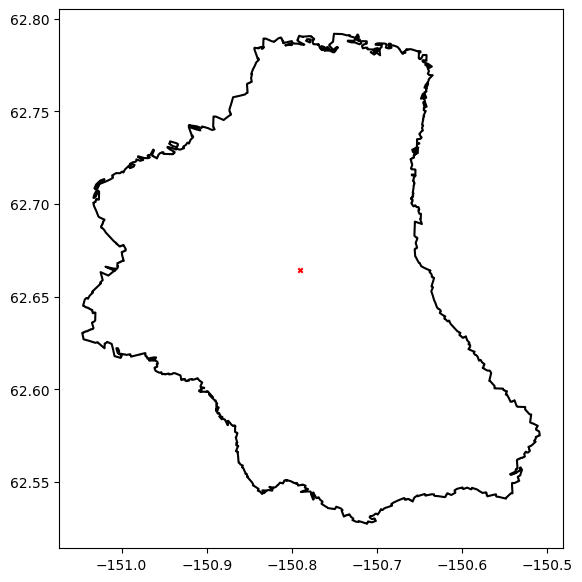

C:\Users\jbrotman-krass\AppData\Local\Temp\1\ipykernel_5304\943917535.py:277: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  FAA = pd.read_csv(FAA_path, sep=",")


duplicate point removed from  N727KT_202104191300
duplicate point removed from  N727KT_202104241300
duplicate point removed from  N727KT_202104251300
duplicate point removed from  N727KT_202104251645
duplicate point removed from  N727KT_202105061630
duplicate point removed from  N727KT_202105061700
duplicate point removed from  N929KT_202103201545
duplicate point removed from  N929KT_202103211330
duplicate point removed from  N929KT_202104071130
duplicate point removed from  N929KT_202104101300
duplicate point removed from  N929KT_202104171030
duplicate point removed from  N929KT_202104261315
Largest polygon chosen as active space
95  hairballs removed (highly erratic data, likely garbage)
removed 135 low quality tracks (only 2 points, very slow, & short)
Interpolating tracks, may take a few minutes:


100%|████████████████████████████████████████████████████████████████████████| 6538/6538 [13:35<00:00,  8.02 splines/s]


---------- Interpolation completed ----------
--------- Updating track parameters ---------
Extracting entry/exit positions
Extracting entry/exit times
Calculating transit duration
Calculating transit distance
Calculating average speed
----- Track parameters update completed -----
------ Clipping tracks to active space ------
Adjusting timestamps to clipped tracks


8877 tracks adjusted [00:25, 346.65 tracks adjusted/s]


------------- Tracks clipped ----------------
--------- Updating track parameters ---------
Extracting entry/exit positions
Extracting entry/exit times
Calculating transit duration
Calculating transit distance
Calculating average speed
----- Track parameters update completed -----
------------- Updating track QC -------------
 - needs extrapolation
 - needs glue
 - very short track
 - erroneous flight speed
------------ Track QC Completed -------------
----------- Data Quality Summary ------------
Needs Extrapolation: 1828  ....  20.59 %
Needs Glue: 1606  ....  18.09%
Short Tracks: 1230  ....  13.86%
Erroneous Average Flight Speed: 470  ....  5.29%
Out of 8877 total tracks
-------------- Cleaning tracks --------------
getting rid of single points...
glueing up segmented tracks...
 - Identifying sets of tracks that should be glued together


8876 checked for needing glue [00:10, 877.01 checked for needing glue/s] 


 - Gluing tracks


  0%|                                                                                 | 0/440 [00:00<?, ? glued sets/s]C:\Users\jbrotman-krass\AppData\Local\miniforge3\envs\active\lib\site-packages\pandas\core\dtypes\cast.py:130: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
100%|██████████████████████████████████████████████████████████████████████| 440/440 [00:02<00:00, 160.70 glued sets/s]


 - Remove duplicates
Glued 440  sets of broken tracks (patch for GeoPandas clipping bug)
removing tracks < 10s in duration
removing tracks with avg speed = 0 or infinity...
-------------- Tracks cleaned ---------------
------------- Updating track QC -------------
 - needs extrapolation
 - needs glue
 - very short track
 - erroneous flight speed
------------ Track QC Completed -------------
----------- Data Quality Summary ------------
Needs Extrapolation: 228  ....  4.69 %
Needs Glue: 0  ....  0.0%
Short Tracks: 3  ....  0.06%
Erroneous Average Flight Speed: 49  ....  1.01%
Out of 4865 total tracks
Extracting track heights above mean sea level (MSL)
Grabbing ground levels from the digital elevation model at track points


4865 tracks [01:23, 58.14 tracks/s] 


Calculating heights above ground level (AGL) for each track...
55  flights downgraded from needs_extrapolation due to takeoffs/landings
Possible takeoffs identified:  24
Possible landings identified:  34
Low AGL takeoffs/landings:  25
High res takeoffs/landings:  7
Sinuosity>=1.1 takeoffs/landings:  2
Physics-based takeoffs/landings 24
------------ Extrapolating tracks -----------
Extending track entries:


173 tracks [00:00, 567.67 tracks/s]


Extending track exits:


173 tracks [00:00, 488.49 tracks/s]


------ Clipping tracks to active space ------
Adjusting timestamps to clipped tracks


212 tracks adjusted [00:00, 530.47 tracks adjusted/s]


------------- Tracks clipped ----------------
--------- Updating track parameters ---------
Extracting entry/exit positions
Extracting entry/exit times
Calculating transit duration
Calculating transit distance
Calculating average speed
----- Track parameters update completed -----
------------- Updating track QC -------------
 - needs extrapolation
 - needs glue
 - very short track
 - erroneous flight speed
------------ Track QC Completed -------------
----------- Data Quality Summary ------------
Needs Extrapolation: 0  ....  0.0 %
Needs Glue: 0  ....  0.0%
Short Tracks: 13  ....  6.13%
Erroneous Average Flight Speed: 19  ....  8.96%
Out of 212 total tracks
-------------- Cleaning tracks --------------
getting rid of single points...
glueing up segmented tracks...
 - Identifying sets of tracks that should be glued together


211 checked for needing glue [00:00, 904.91 checked for needing glue/s]


 - Gluing tracks


0 glued sets [00:00, ? glued sets/s]


 - Remove duplicates
Glued 0  sets of broken tracks (patch for GeoPandas clipping bug)
removing tracks < 10s in duration
removing tracks with avg speed = 0 or infinity...
-------------- Tracks cleaned ---------------
--------- Updating track parameters ---------
Extracting entry/exit positions
Extracting entry/exit times
Calculating transit duration
Calculating transit distance
Calculating average speed
----- Track parameters update completed -----
------------- Updating track QC -------------
 - needs extrapolation
 - needs glue
 - very short track
 - erroneous flight speed
------------ Track QC Completed -------------
----------- Data Quality Summary ------------
Needs Extrapolation: 0  ....  0.0 %
Needs Glue: 0  ....  0.0%
Short Tracks: 0  ....  0.0%
Erroneous Average Flight Speed: 6  ....  3.35%
Out of 179 total tracks
--------- Extrapolation complete ------------
----------- Data Quality Summary ------------
Needs Extrapolation: 0  ....  0.0 %
Needs Glue: 0  ....  0.0%
Short Track

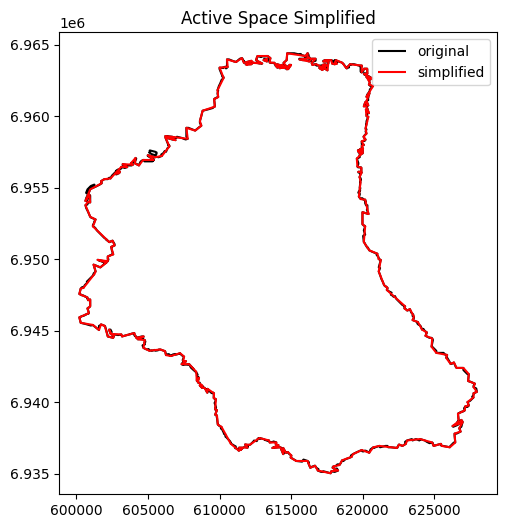

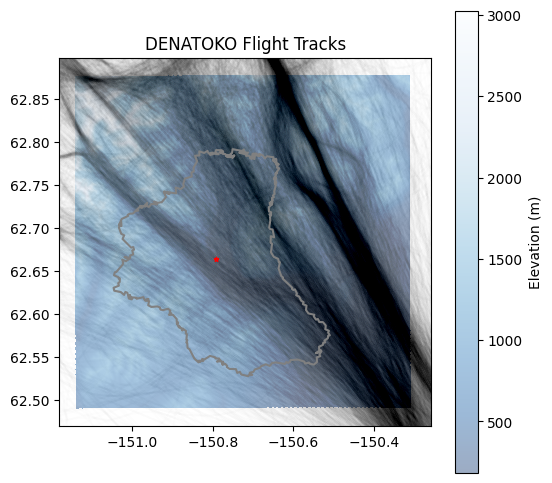

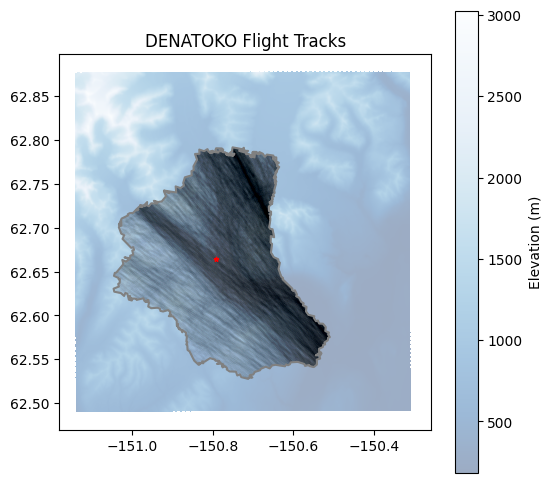

In [13]:
if database_type == 'GPS':
    listener = AudibleTransitsGPS(metadata, paths)
elif database_type == 'ADSB':
    listener = AudibleTransitsADSB(metadata, paths)

listener.init_spatial_data()
listener.load_DEM()
listener.load_tracks_from_database()

listener.extract_aircraft_info()
listener.remove_jets()

listener.convert_tracks_to_utm()
listener.convert_active_to_utm()

listener.create_segments()

raw_tracks = listener.tracks.copy()
listener.simplify_active_space()

listener.tracks, hairballs = AudibleTransits.remove_hairballs(listener.tracks, listener.active, return_hairballs=True)

AudibleTransits.find_poor_tracks(listener.tracks)

AudibleTransits.get_sampling_interval(listener.tracks)

listener.interpolate_tracks()
interpolated_tracks = listener.tracks.copy()

listener.update_track_parameters()
listener.visualize_tracks(show_DEM=True)

listener.clip_tracks()
listener.update_track_parameters()
listener.update_trackQC()
listener.summarize_data_quality()

listener.clean_tracks()
listener.update_trackQC()
listener.summarize_data_quality()

### EXTRAPOLATION ===================================================================================#
if listener.tracks.needs_extrapolation.sum() > 0:
    listener.detect_takeoffs_and_landings()
    final_tracks, extrapolated_tracks = listener.extrapolate_tracks(return_extrapolated=True)

listener.summarize_data_quality()
listener.visualize_tracks(show_DEM=True)

In [14]:
### ENTER IN UNIT, SITE, YEAR, GAIN, START DATE, END DATE ###
unit = 'DENA'
site = 'FANG'
year = 2018
gain = -1.5
study_start = "2018-01-01"
study_end = dt.datetime.now()

# Path to FAA aircraft data, useful for getting info about each aircraft 
FAA_path = r"V:\Noncanonical Data\ReleasableAircraft\MASTER.txt"
aircraft_corrections_path = r"V:\Noncanonical Data\ReleasableAircraft\FAA_AircraftCorrections.txt"

ADSB_DIR = r'C:\Users\jbrotman-krass\Documents\ADSBdata\2023 ADS-B Healy Repeater\TSV\merge'
#ADSB_DIR = r"C:\Users\jbrotman-krass\Documents\ADSBdata\K'esugi\merged"
#ADSB_DIR = r'C:\Users\jbrotman-krass\Documents\ADSBdata\sample'

database_type = 'ADSB'

metadata = {"unit": unit, "site": site, "year": year, "gain": gain, "study start": study_start, "study end": study_end, "database type": database_type}
paths = {"FAA": FAA_path, "aircraft corrections": aircraft_corrections_path, "ADSB": ADSB_DIR}

In [ ]:
if database_type == 'GPS':
    listener2 = AudibleTransitsGPS(metadata, paths)
elif database_type == 'ADSB':
    listener2 = AudibleTransitsADSB(metadata, paths)

listener2.init_spatial_data()
listener2.load_DEM()
listener2.load_tracks_from_database()

listener2.extract_aircraft_info()
listener2.remove_jets()

listener2.convert_tracks_to_utm()
listener2.convert_active_to_utm()

listener2.create_segments()

raw_tracks2 = listener2.tracks.copy()
listener2.simplify_active_space()

listener2.tracks, hairballs2 = AudibleTransits.remove_hairballs(listener2.tracks, listener2.active, return_hairballs=True)

AudibleTransits.find_poor_tracks(listener2.tracks)

AudibleTransits.get_sampling_interval(listener2.tracks)

listener2.interpolate_tracks()
interpolated_tracks2 = listener2.tracks.copy()

listener2.update_track_parameters()
listener2.visualize_tracks(show_DEM=True)

listener2.clip_tracks()
listener2.update_track_parameters()
listener2.update_trackQC()
listener2.summarize_data_quality()

listener2.clean_tracks()
listener2.update_trackQC()
listener2.summarize_data_quality()

### EXTRAPOLATION ===================================================================================#
if listener2.tracks.needs_extrapolation.sum() > 0:
    listener2.detect_takeoffs_and_landings()
    final_tracks2, extrapolated_tracks2 = listener2.extrapolate_tracks(return_extrapolated=True)

listener2.summarize_data_quality()
listener2.visualize_tracks(show_DEM=True)